In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')

# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'psth_postVSrenew'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'plot_it', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'plot_panel', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'plot_patches', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [6]:
vars_pre = {}
folder = '../post/notebooks/autorestore/preprocessing/'
for var in ('time_ax', 'time_ax_single', 'events', 'cycles', 'is_CSmt', 'is_rewardt', 'traces', 'areas',
            'odor_CSm_ons', 'odor_CSm_offs',
            'odor_rw_ons', 'odor_rw_offs',
            'CYCLE_START', 'CS_DURATION',
            'licks'): 
    vars_pre.update({var:ut.load_variable(var, folder=folder)})
folder = '../post/notebooks/autorestore/selectivity/'
for var in ('selectivity',): 
    vars_pre.update({var:ut.load_variable(var, folder=folder)})

    
vars_post = {}
folder = '../renew/notebooks/autorestore/preprocessing'
for var in ('time_ax', 'time_ax_single', 'events', 'cycles', 'is_CSmt', 'is_rewardt', 'traces', 'areas',
            'odor_CSm_ons', 'odor_CSm_offs',
            'odor_rw_ons', 'odor_rw_offs',
            'CYCLE_START', 'CS_DURATION',
            'licks'):
    vars_post.update({var:ut.load_variable(var, folder=folder)})
folder = '../renew/notebooks/autorestore/selectivity/'
for var in ('selectivity',): 
    vars_post.update({var:ut.load_variable(var, folder=folder)})


In [7]:
conditions = ['post', 'renew']
cellregs = ut.load_variable('cellregs', './autorestore/decoding_postVSrenew')

In [8]:
import scipy.stats as sstats

In [9]:
rhos = []
for cell_pre, cell_post in zip(cellregs['post'], cellregs['renew']):
    
    rhos_od = []
    for isopre, isopost in zip([vars_pre['is_CSmt'], vars_pre['is_rewardt']],
                               [vars_post['is_CSmt'], vars_post['is_rewardt']]):
        alldffspre = ut.compute_all_dffs(vars_pre['time_ax'], vars_pre['events'], cell_pre,
                                         vars_pre['cycles'][isopre], vars_pre['time_ax_single'])
        alldffspost = ut.compute_all_dffs(vars_post['time_ax'], vars_post['events'], cell_post,
                                          vars_post['cycles'][isopost], vars_post['time_ax_single'])

        mpre = np.mean(alldffspre, 0)
        mpost = np.mean(alldffspost, 0)
        
        t_pre, t_post = [vars_pre['CS_DURATION']]*2
        t_filter_pre = (vars_pre['time_ax_single']>-t_pre) * (vars_pre['time_ax_single']<vars_pre['CS_DURATION']+t_post)
        t_pre, t_post = [vars_post['CS_DURATION']]*2
        t_filter_post = (vars_post['time_ax_single']>-t_pre) * (vars_post['time_ax_single']<vars_post['CS_DURATION']+t_post)
        rhos_od.append(sstats.pearsonr(mpre[t_filter_pre], mpost[t_filter_post])[0])
    rhos.append(rhos_od)
    
    print ".",
rhos = np.r_[rhos]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [10]:
best_rhos_odor1 = cellregs['post'][np.argsort(rhos[:, 0])[::-1]]

In [11]:
time_ax = vars_pre['time_ax']
CS_DURATION = vars_pre['CS_DURATION']

In [12]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon
def plot_patches(areas, cells, background=False, color='r', alpha=0.3, lw=0, ax=None, **args):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(2, 2))

    ax.imshow(np.zeros_like(areas[0]), alpha=0)
    patches = []
    for cell in cells:
        contours = np.r_[find_contours(areas[cell]>0, 0.5)]
        polygon = Polygon(contours[0], color=color, alpha=alpha, lw=0, **args)
        ax.add_patch(polygon)
        
    if background:
        plot_patches(areas, np.delete(range(len(areas)), cells), color="0.7", ax=ax, zorder=0)

    ax.set_xticks(())
    ax.set_yticks(());

In [13]:
def plot_it(events, evs_means, cell, odon, odoff, ax0, ax1, vmin=0, vmax=5, t_pre=2, t_post=4, cmap=pl.cm.gray_r,
            putnans=False, thr=False, traces=True, scale=False, lick_ts=[]):

    psth = []
    licks_t =[] #first lick
    lick_t_all=[]

    ons, offs = odon, odoff
    ons_offs = zip(ons, offs)

    for start, stop in zip(ons, offs):
        if start+t_post>time_ax[-1] or start-t_pre<time_ax[0]:
            ons_offs.remove((start,stop))
            continue
        nstart = np.min(np.where(time_ax>=(start-t_pre)))
        nstop = nstart + int((CS_DURATION+t_pre+t_post)/delta_t)
        psth.append(events[:, cell][nstart:nstop]/evs_means[cell])
    
    if len(psth[-1])<len(psth[0]):
        psth = psth[:-1]
    psth = np.r_[psth]
    
    if len(lick_ts)!=0:
        for start, stop in ons_offs:
            l = lick_ts - start
            if sum(l>0)>0:
                licks_t.append(l[np.argwhere(l>0)[0][0]])
                lick_t_all.append(np.array(l[(l>-t_pre)*(l<(CS_DURATION+t_post))]))
            else:
                licks_t.append(CS_DURATION+t_post+10)
                lick_t_all.append([])
    
    licks_t=np.r_[licks_t]       
    trial_ind=np.argsort(licks_t)
    psth=psth[trial_ind,:]
    licks_t=licks_t[trial_ind]
    
    if thr:
        psth = (psth>0)*1.
        vmax = 1
    t = np.linspace(-t_pre, t_post+CS_DURATION, psth.shape[1])
    if traces:
        m = psth.mean(0)*5
        s = sstats.sem(psth, 0)*5
        ax0.plot(t, m, color='k', lw=0.5)
        ax0.fill_between(t, m-s, m+s, color='0.7', lw=0, zorder=0)
        if scale:
            pt.draw_scale_line_xy(ax0, (0, 1), lw=1, offset=(1, 1))
    else:
        ax0.bar(t, psth.mean(0), align='edge', color='k')

    if putnans:
        psth[psth==0] = np.nan
        
    im = ax1.imshow(psth, cmap=cmap, vmin=vmin, vmax=vmax,
               extent=(-t_pre, t_post+CS_DURATION, 0, len(ons)), aspect='auto', origin='lower')
    
    for i in range(0,len(licks_t)):
        ax1.plot(licks_t[i],i,'ro',markersize=0.1)
        # if you want to plot all licks
#        try:
#            ax1.plot(lick_t_all[trial_ind[i]],i*np.ones(len(lick_t_all[trial_ind[i]])),'bo',markersize=0.1)
#        except:
#            pass

#     t = np.linspace(-t_pre, t_post+CS_DURATION, psth.shape[1]+2)
#     ax0.hist(t[np.nonzero(psth)[1]], bins=t, color='k', lw=0, histtype='stepfilled')
    

#     ax0.bar(range(psth.shape[1]), psth.sum(0), color='k', lw=0, width=width)
#     ax0.set_ylim(-10, 300)
    for s in ax0.spines.values():
        s.set_visible(False)
    ax0.set_xticks(())
    ax0.set_yticks(())
    pt.nicer_plot(ax1)

    ax0.set_xlim(-t_pre, t_post+CS_DURATION)
    ax1.set_xlim(-t_pre, t_post+CS_DURATION)

    return im

In [14]:
test=[]
test.append([2,3,4])
test.append([])
test

[[2, 3, 4], []]

In [15]:
vars_pre.keys()

['odor_rw_ons',
 'selectivity',
 'licks',
 'time_ax',
 'is_CSmt',
 'odor_rw_offs',
 'time_ax_single',
 'odor_CSm_ons',
 'CYCLE_START',
 'is_rewardt',
 'CS_DURATION',
 'odor_CSm_offs',
 'cycles',
 'traces',
 'events',
 'areas']

In [16]:
delta_t = np.diff(time_ax)[0]

def plot_panel(axs, cell, t_pre=6, t_post=6, delta_t=delta_t, prepost='post', 
               cmap=pl.cm.gray_r, putnans=False, thr=False, vmin=0, vmax=5, with_traces=False):
    
    for k in vars_pre.keys():
#         if k == 'areas': continue
        exec('%s = vars_%s[\'%s\']' % (k, 'pre' if prepost=='post' else 'post', k))
#     areas = vars_pre['areas']
    bool_filter = np.r_[[False]*len(events)]

    baseline_period = [-CS_DURATION, 0]

    for s, e in cycles:
        bool_filter[(time_ax>=(s-CYCLE_START+baseline_period[0])) *
                    (time_ax<(s-CYCLE_START+baseline_period[1]))] = True

    evs_means = np.zeros(len(cellregs['post']))
    for c in xrange(evs_means.shape[0]):
        evs_means[c] = events[:, cellregs[prepost][c]][bool_filter * (events[:, cellregs[prepost][c]]>0)].mean(0)
    im = plot_it(events[:, cellregs[prepost]], evs_means, cell, odor_CSm_ons, odor_CSm_offs, axs[0][1], axs[1][1], t_pre=t_pre, t_post=t_post,
                 cmap=cmap, putnans=putnans, thr=thr, vmin=vmin, traces=with_traces, scale=True, lick_ts=licks)
#         im.set_clim(vmin, vmax)
    plot_it(events[:, cellregs[prepost]], evs_means, cell, odor_rw_ons, odor_rw_offs, axs[0][2], axs[1][2], t_pre=t_pre, t_post=t_post,
            cmap=cmap, putnans=putnans, thr=thr, vmin=vmin, traces=with_traces, scale=True, lick_ts=licks)
#     ax = fig.add_axes((0.9, 0.2, 0.02, 0.6))
    ax = axs[1][-1]
    fig.colorbar(im, cax=ax, orientation='vertical', ticks=(0, 5), boundaries=np.linspace(0, vmax, 256))
    ax.set_xticks(())
    ax.set_yticks((0, 10))
    ax.text(-0.5, 0.7, 'Normalized event magnitude', rotation=90, ha='center', fontsize=3)
    pt.remove_axes(axs[0][-1])

    for s in ax.spines.values():
        s.set_visible(False)
    for s in axs[0][0].spines.values():
        s.set_visible(False)
    axs[0][0].set_xticks(())
    axs[0][0].set_yticks(())

    for ax in axs.T[1:]:
        ax[1].set_yticks(())
        ymin, ymax = ax[1].axis()[-2:]
        ax[1].fill_between([0, 2], ymax+ymax/20., ymax+ymax/20.+ymax/50., color='g', lw=0)
        ax[1].fill_between([2, 4], ymax+ymax/20., ymax+ymax/20.+ymax/50., color='0.5', lw=0)
        ax[0].set_ylim(-0.1, 5)
    axs[1][1].set_xlabel('Time (s)', fontsize=5)
    # axs[0][1].text(29, 200, 'Cell %3d' % cell, fontsize=5, ha='center')

    axs[0][1].text(-5, -1, 'CS-', fontsize=3)
    axs[0][2].text(-5, -1, 'CS+', fontsize=3)

    axs[1][1].set_ylabel('Trial #', fontsize=5)
    # axs[0][0].set_title('Air', fontsize=5)
    # axs[0][1].set_title('Banana', fontsize=5)
    # axs[0][2].set_title('Flower', fontsize=5)

    plot_patches(areas[cellregs[prepost]], [cell],
                 ax=axs[1][0], background=True, alpha=1)
    axs[1][0].text(50, 100, "Cell %d"%cellregs[prepost][cell], fontsize=5)

    #     fig.tight_layout()
#     fig.subplots_adjust(bottom=0.3, left=0., right=0.75)

#         fig.savefig('../img/psth_%03d.pdf'%cell)
    
    return


/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


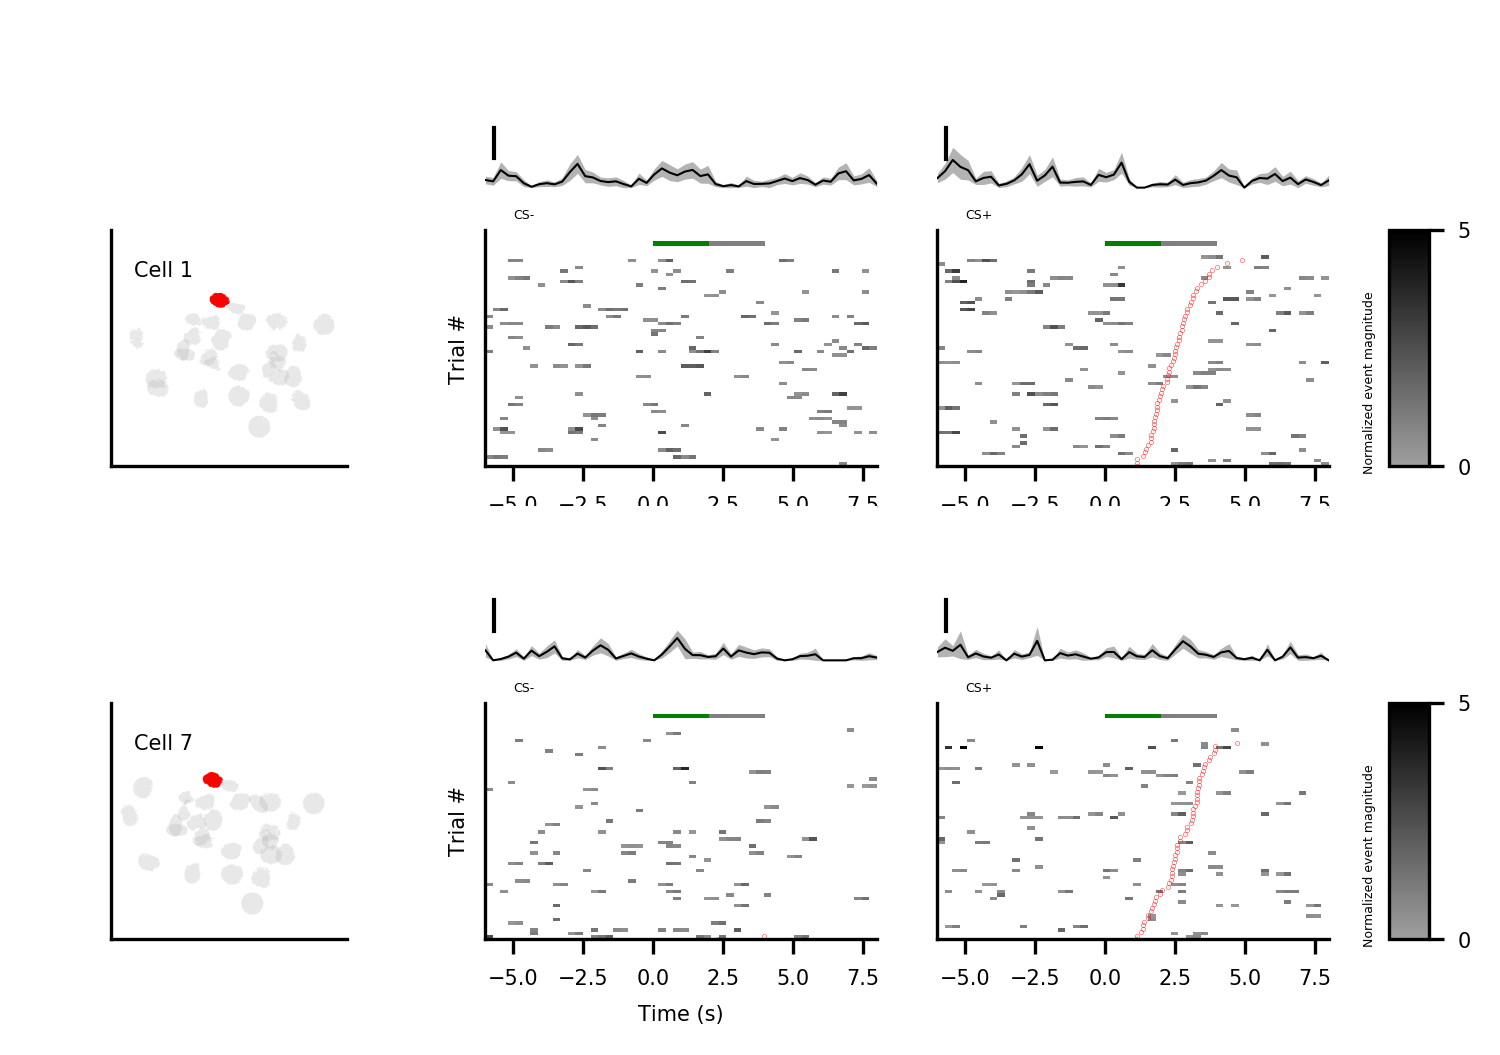

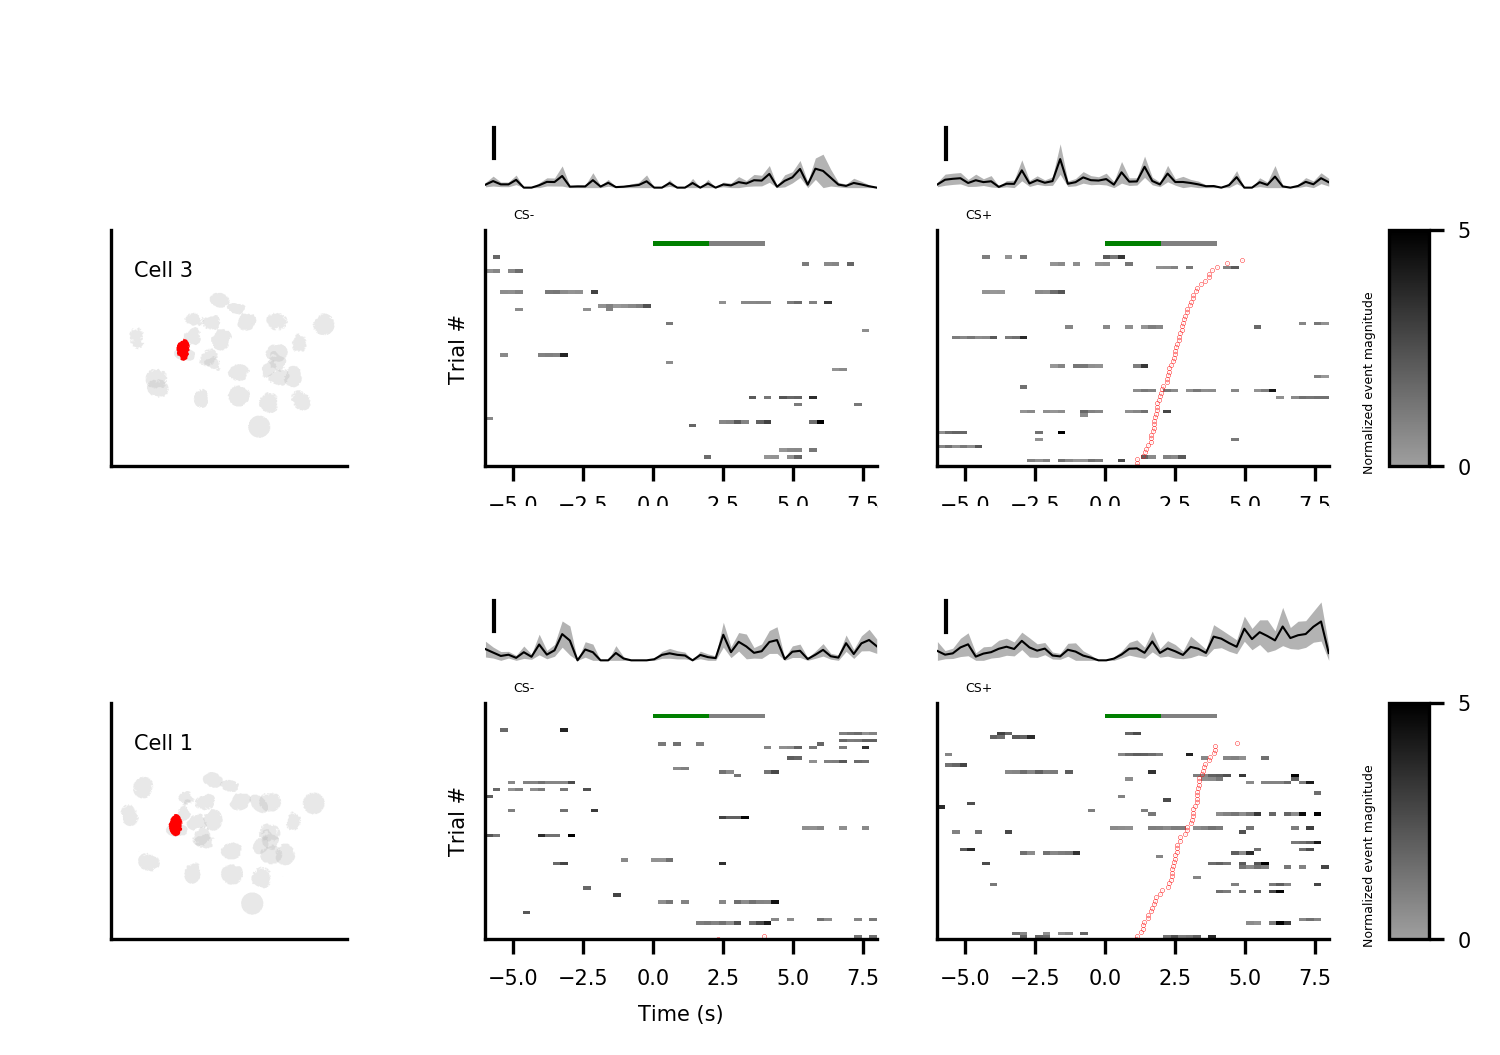

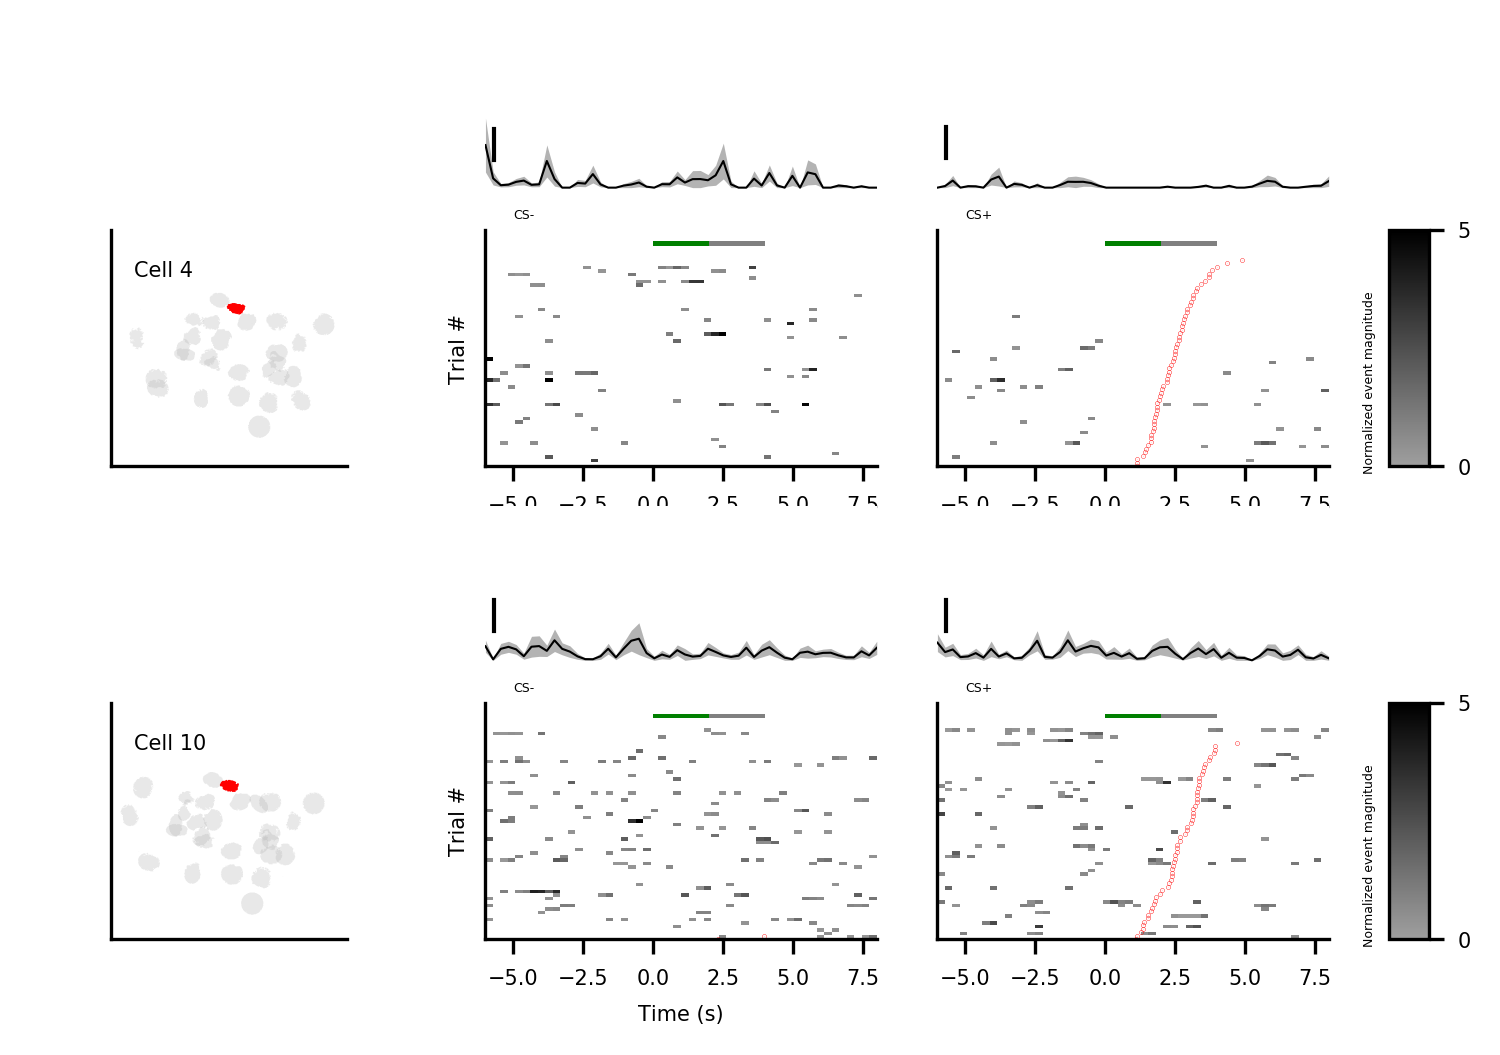

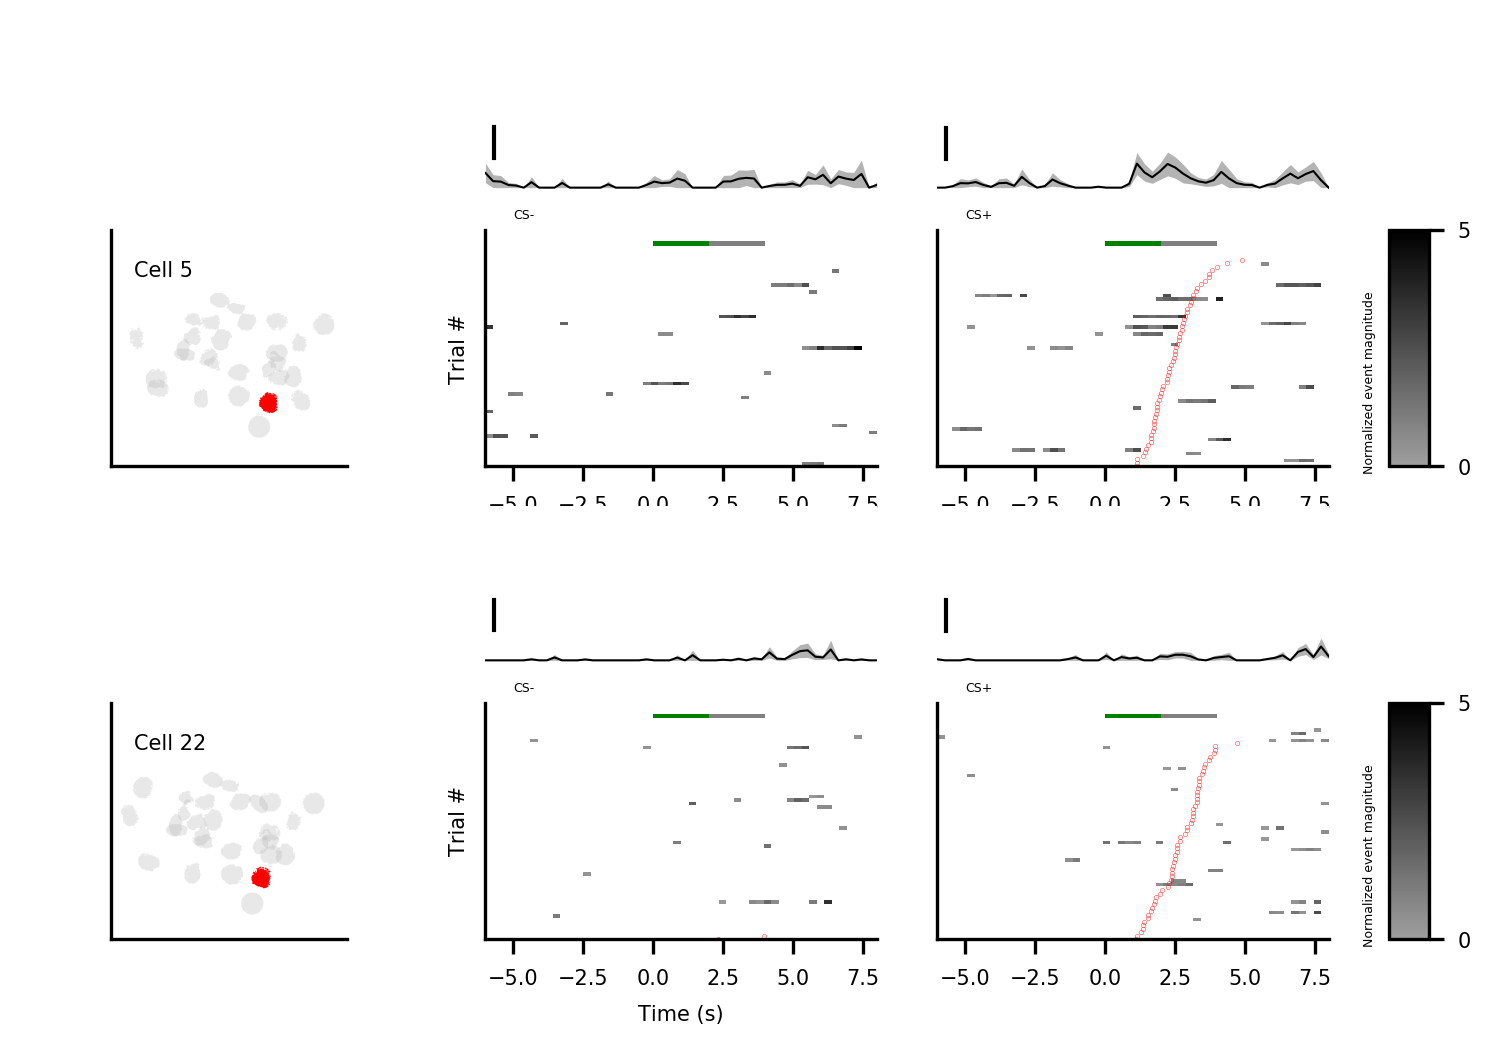

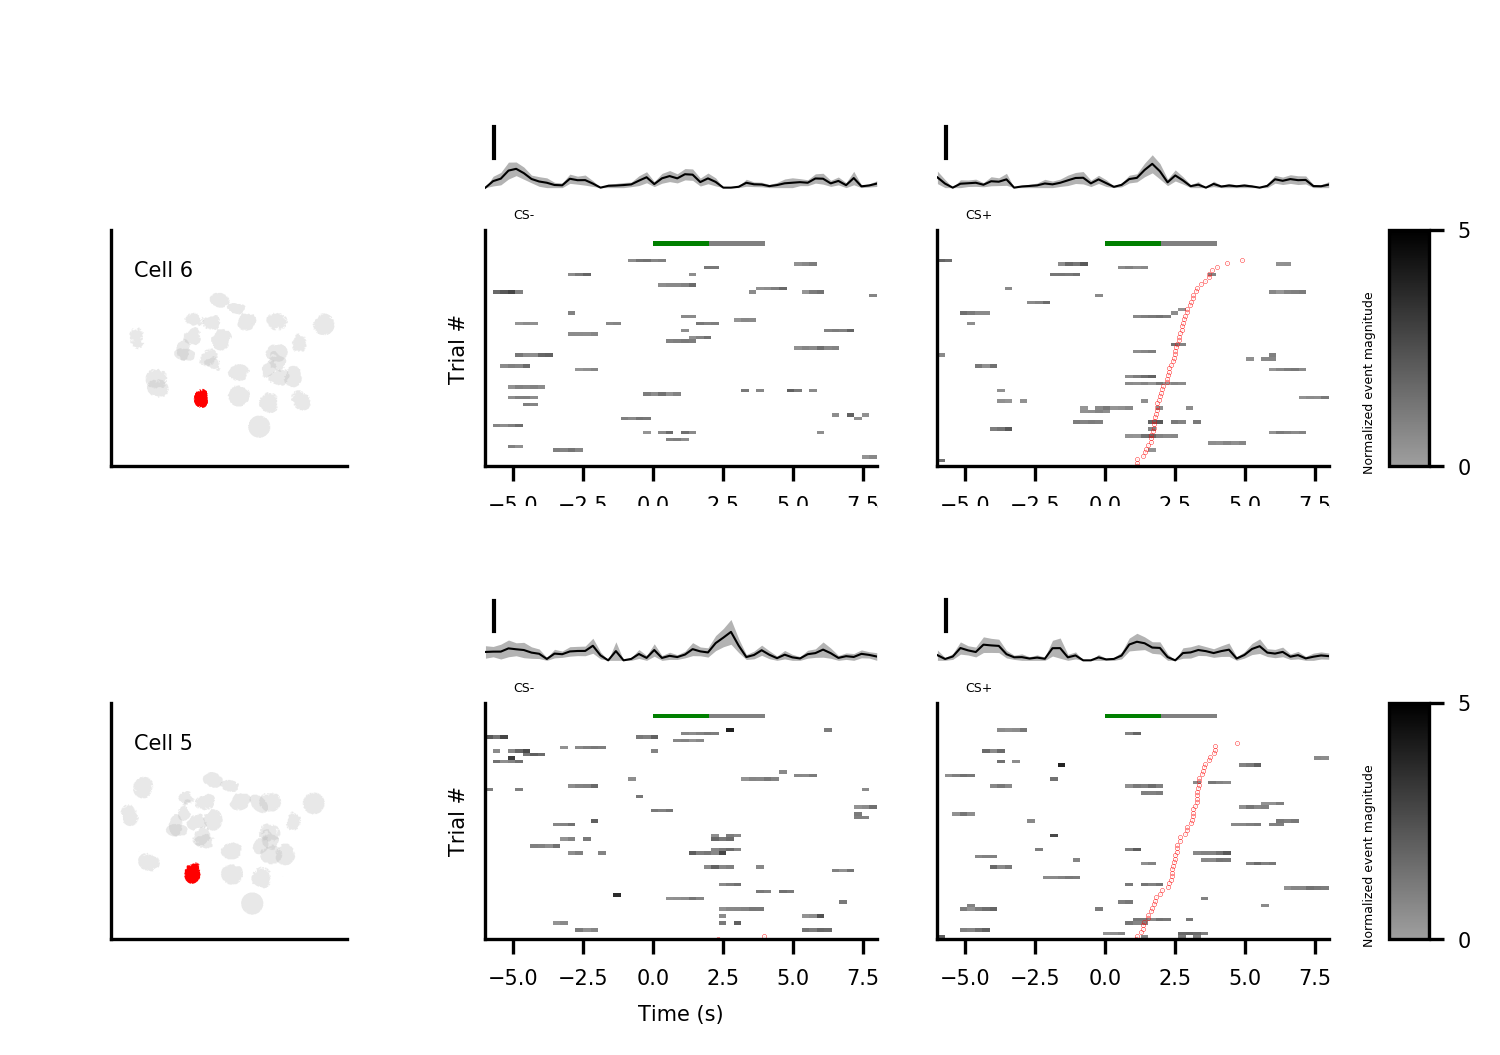

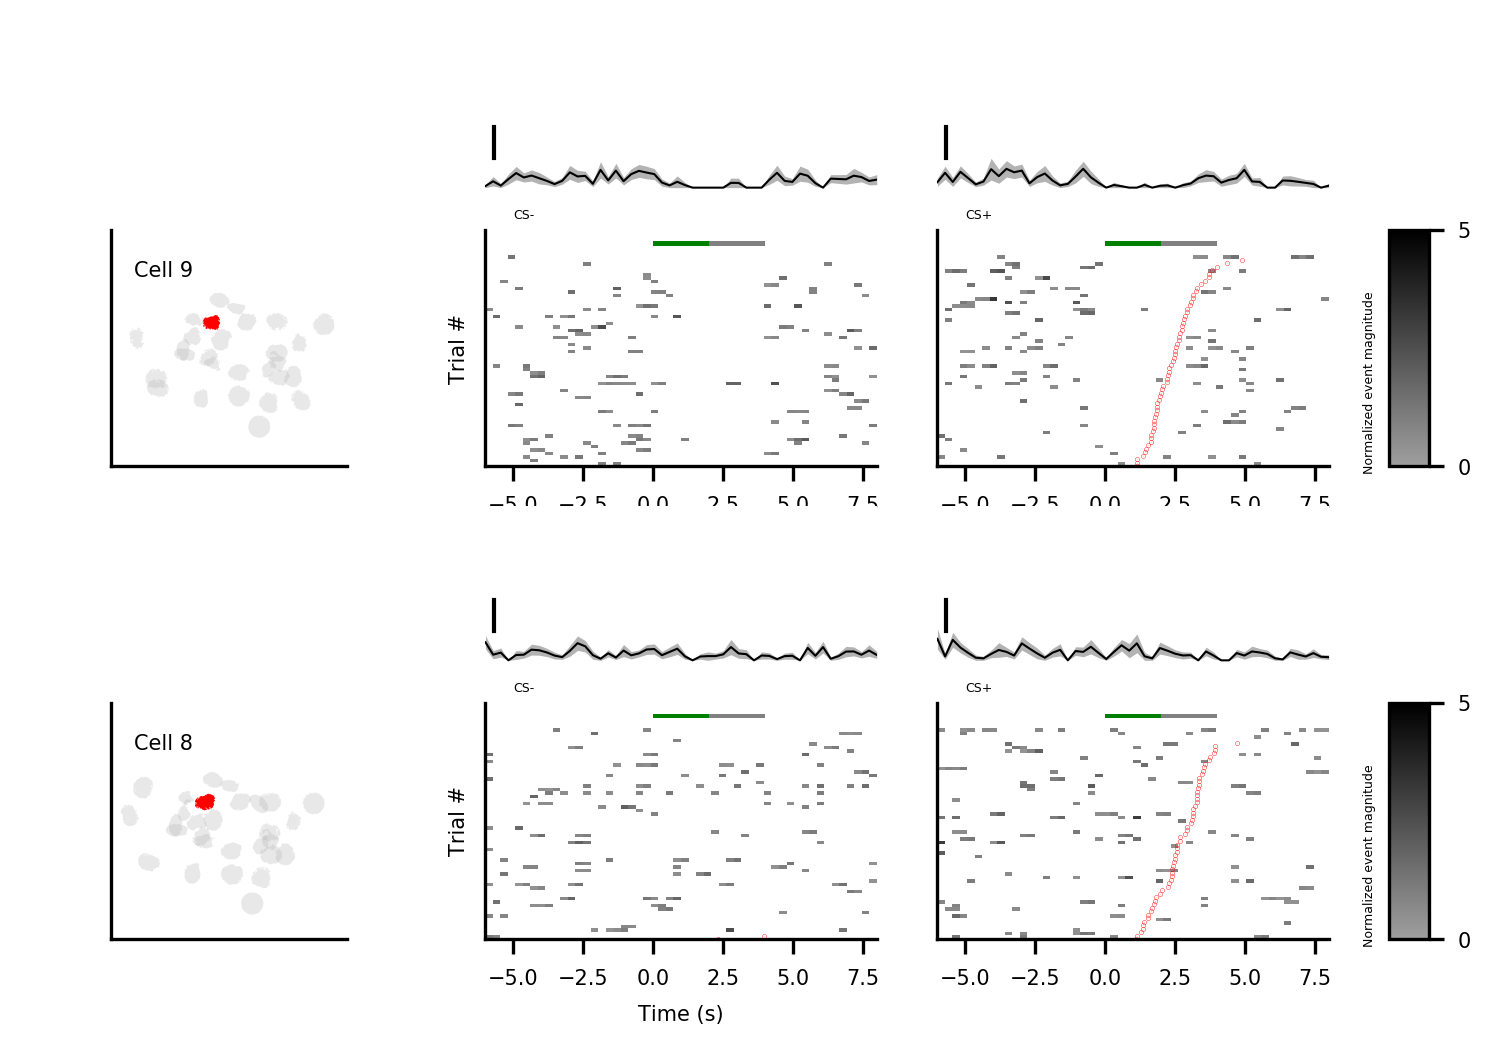

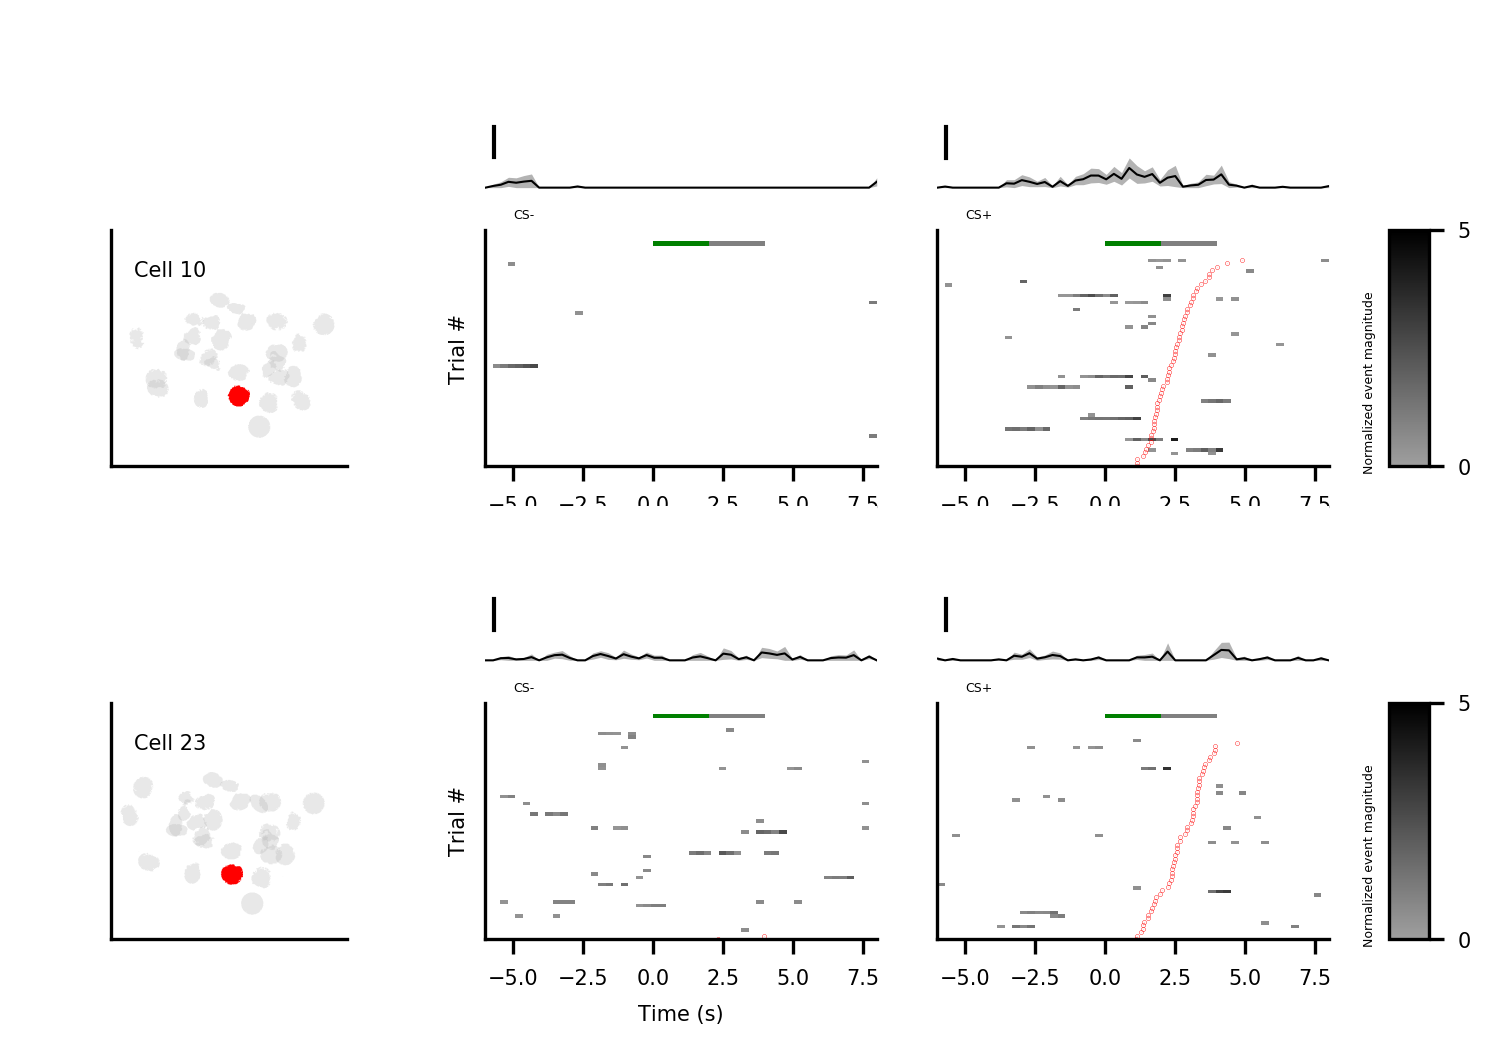

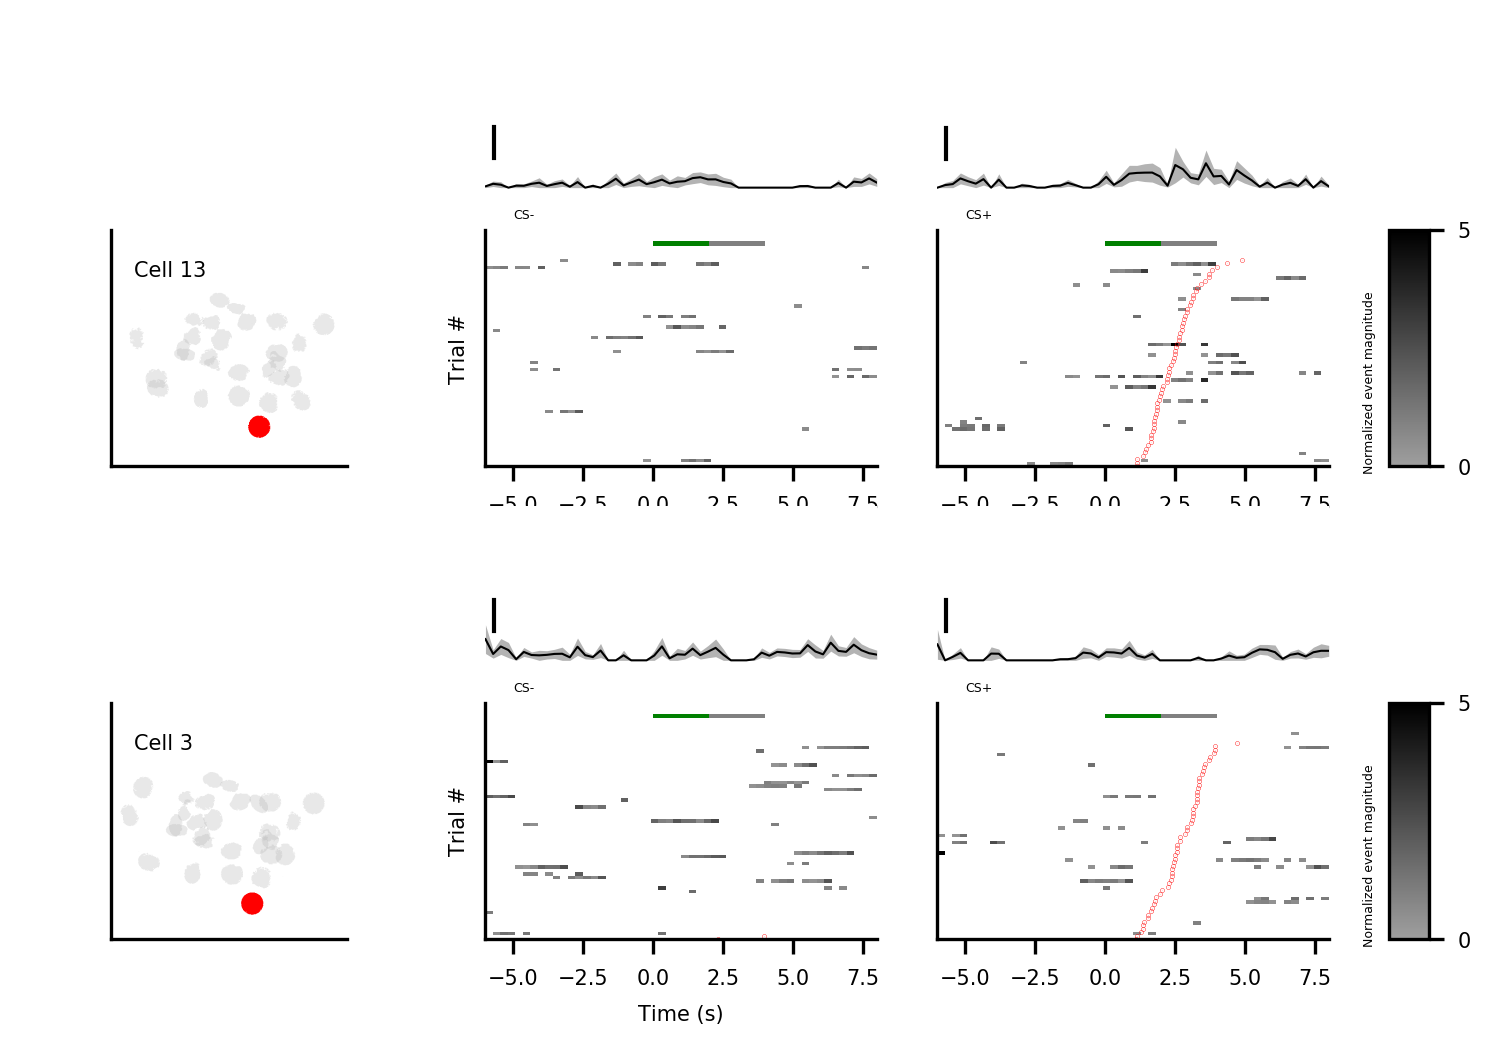

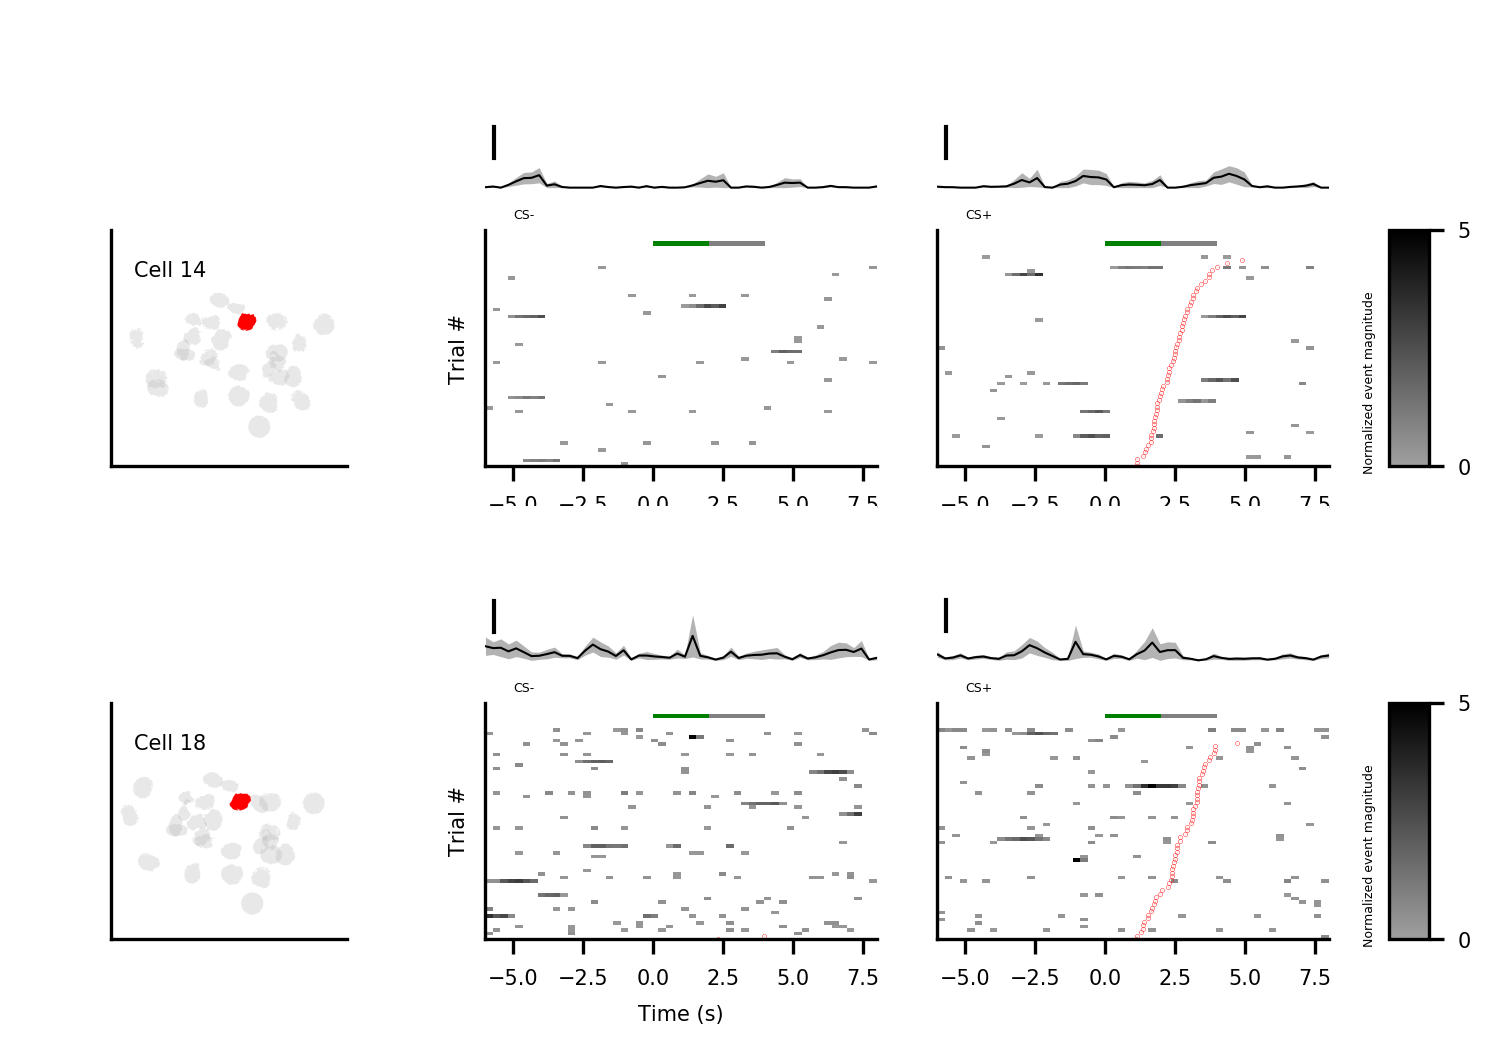

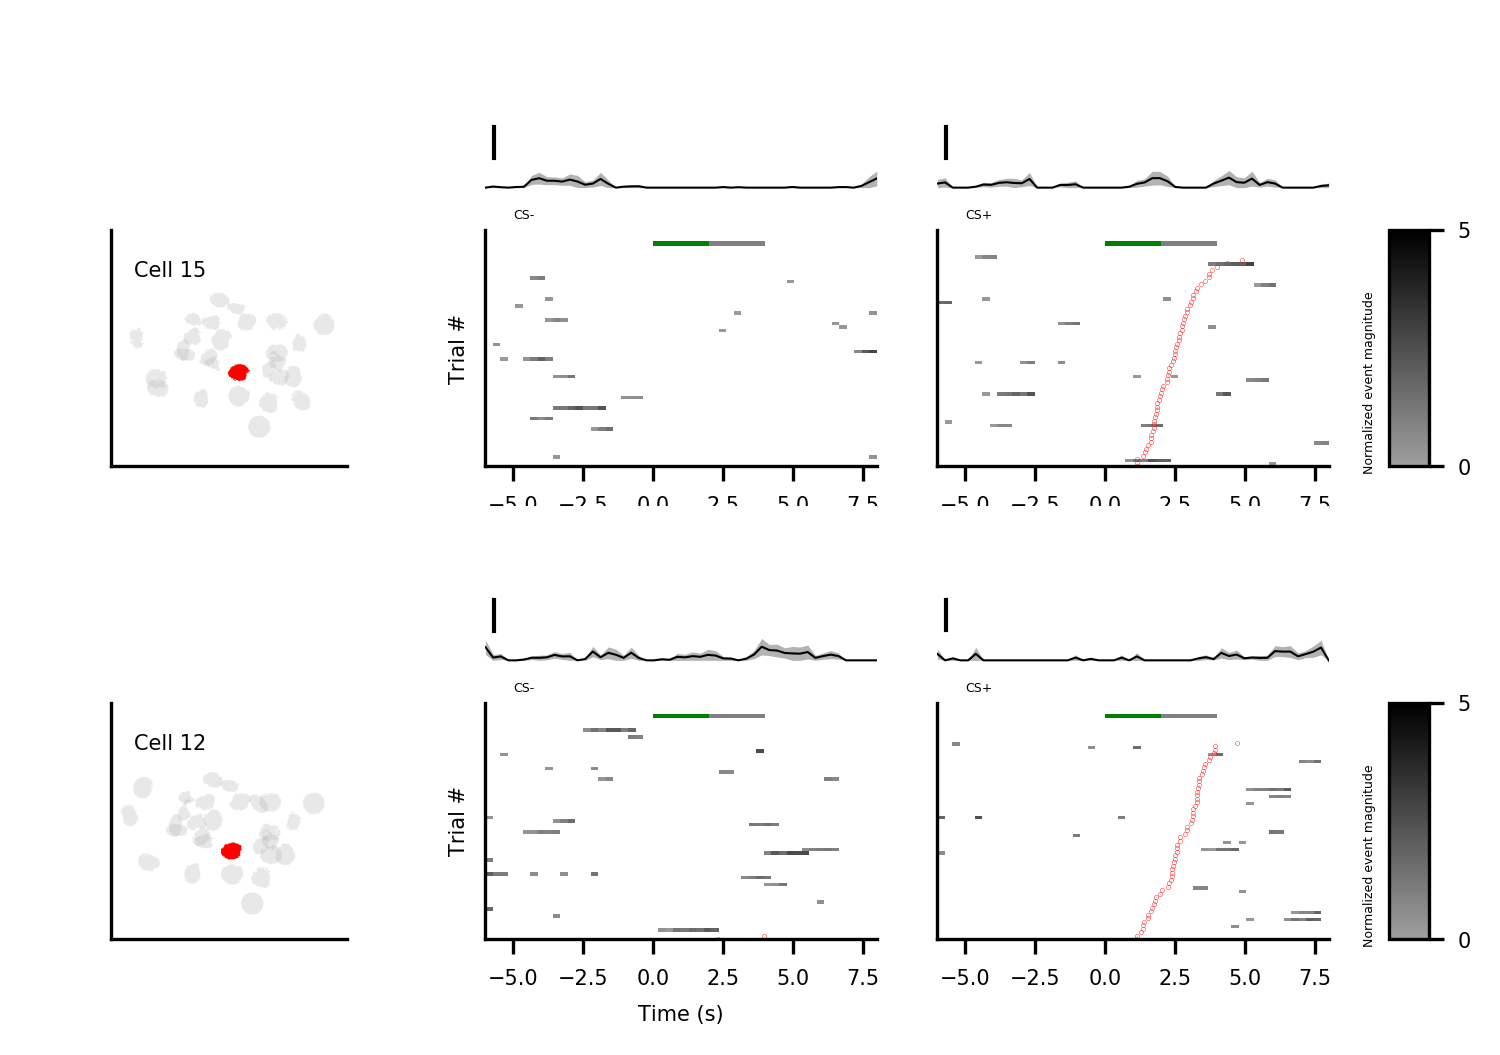

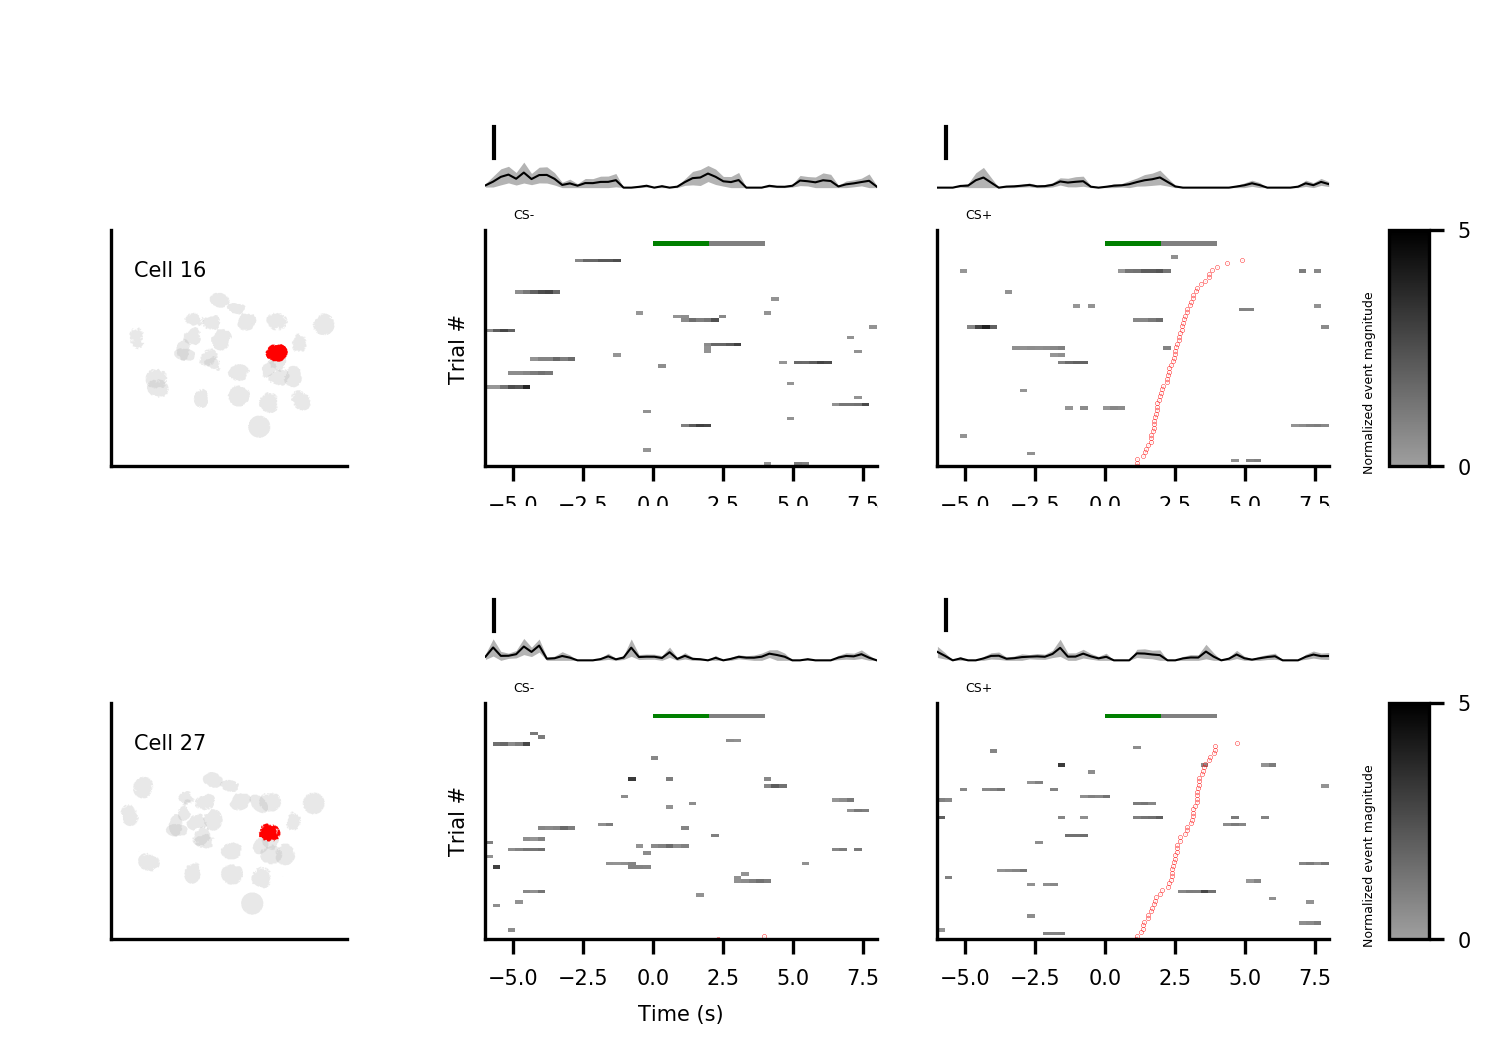

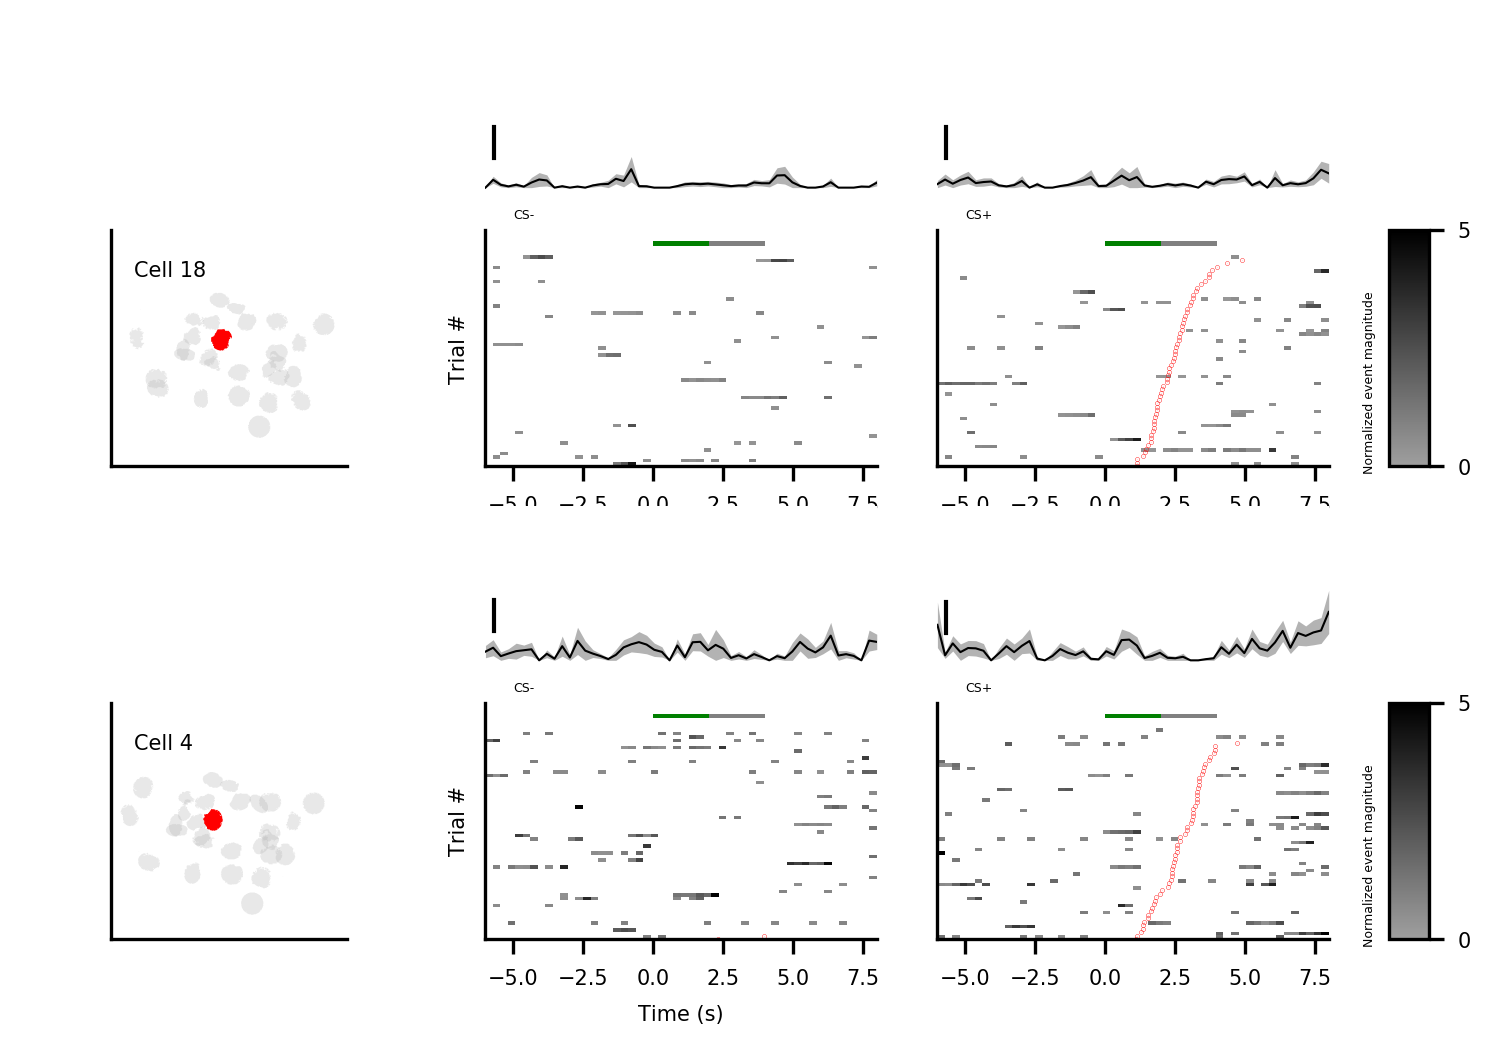

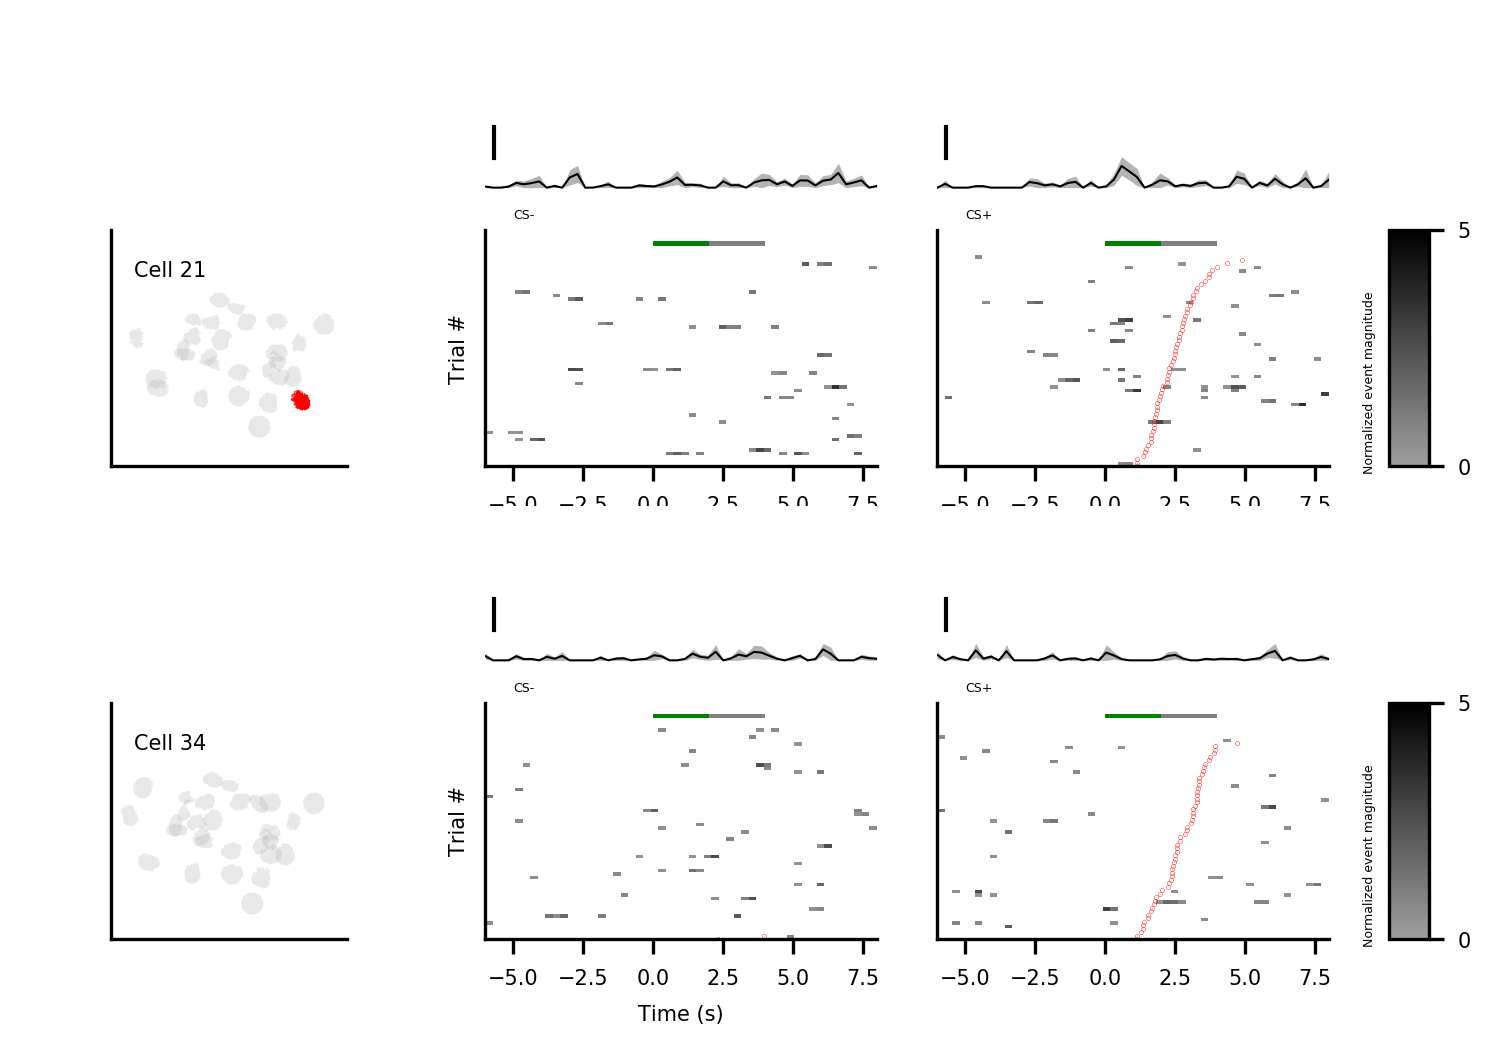

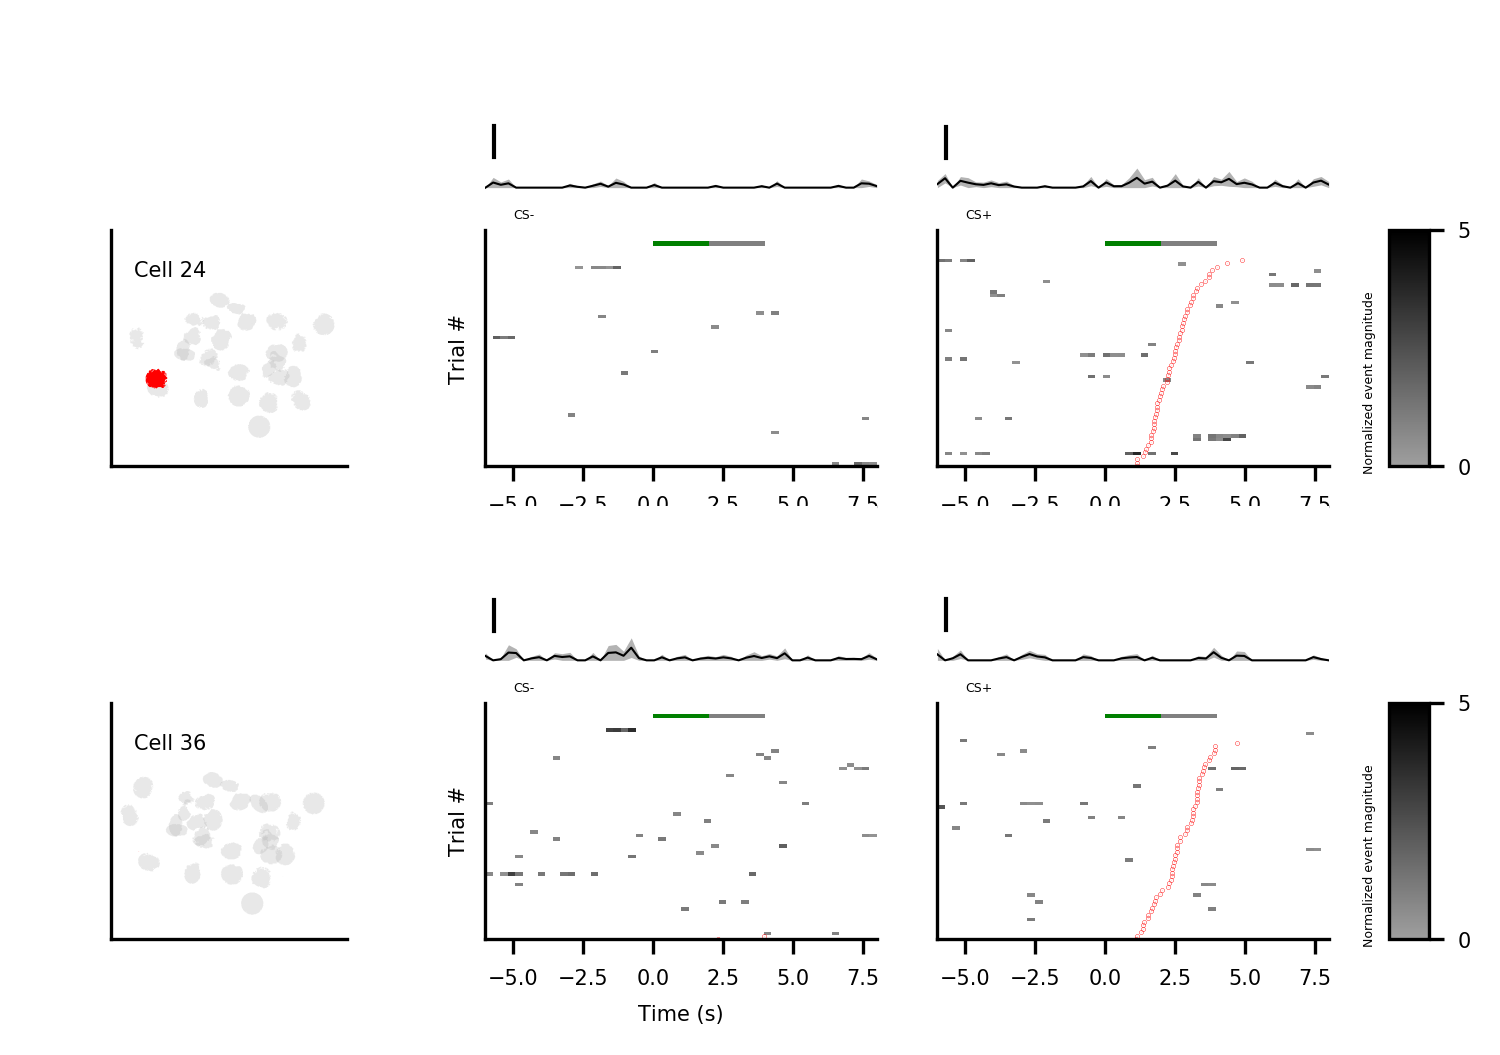

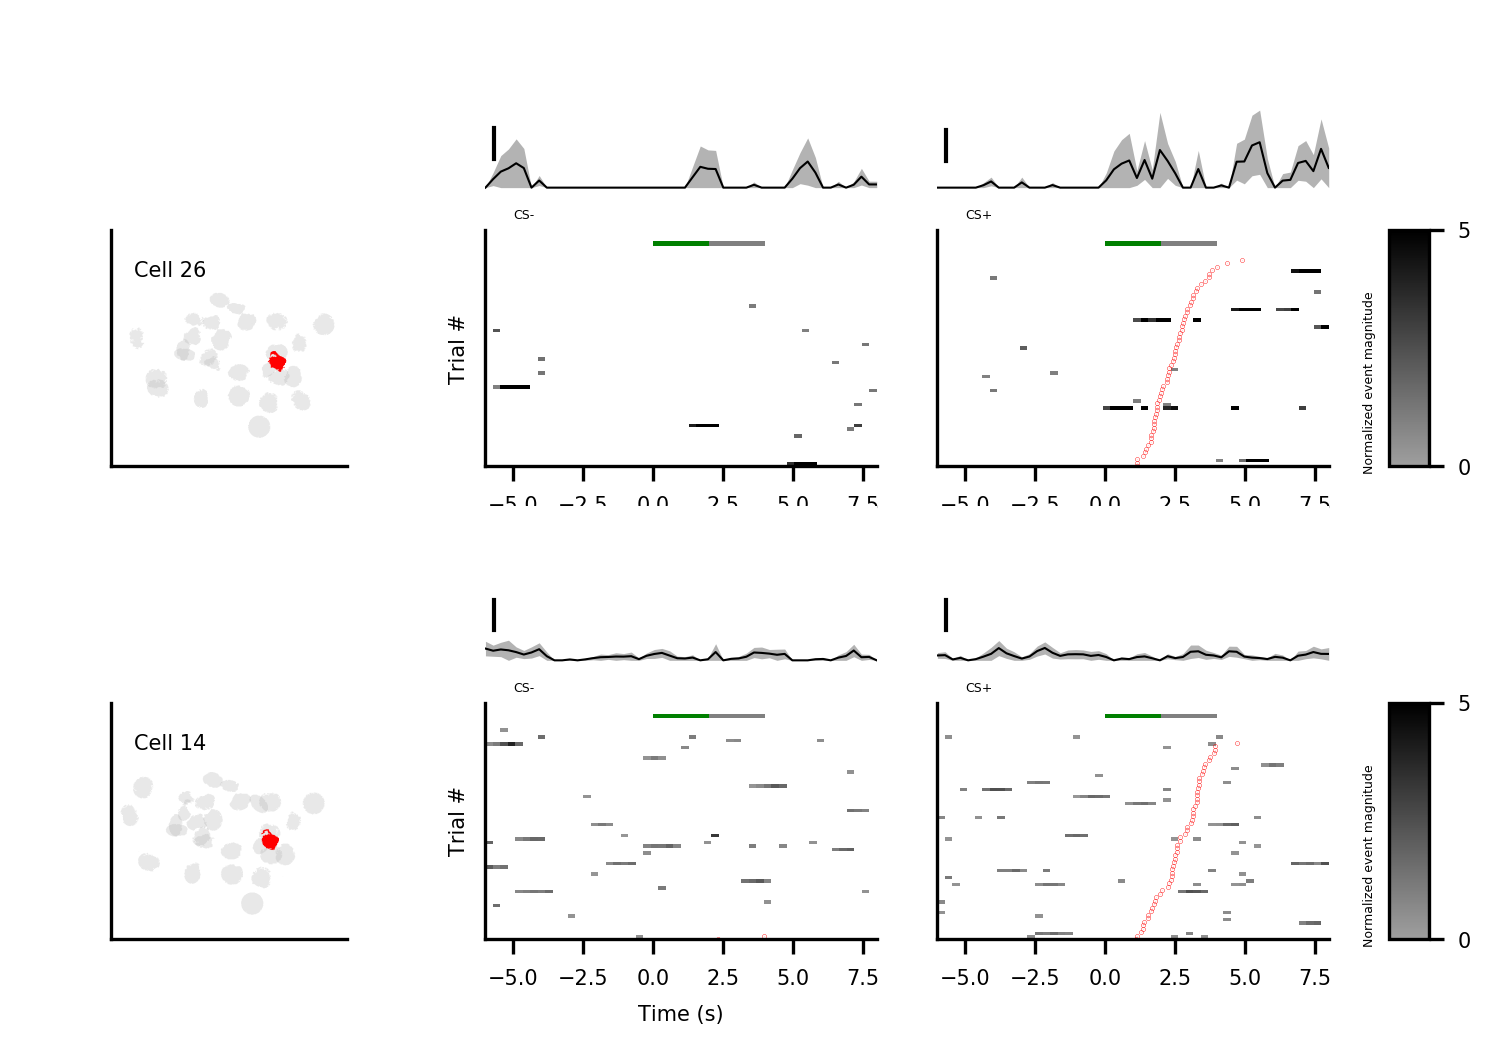

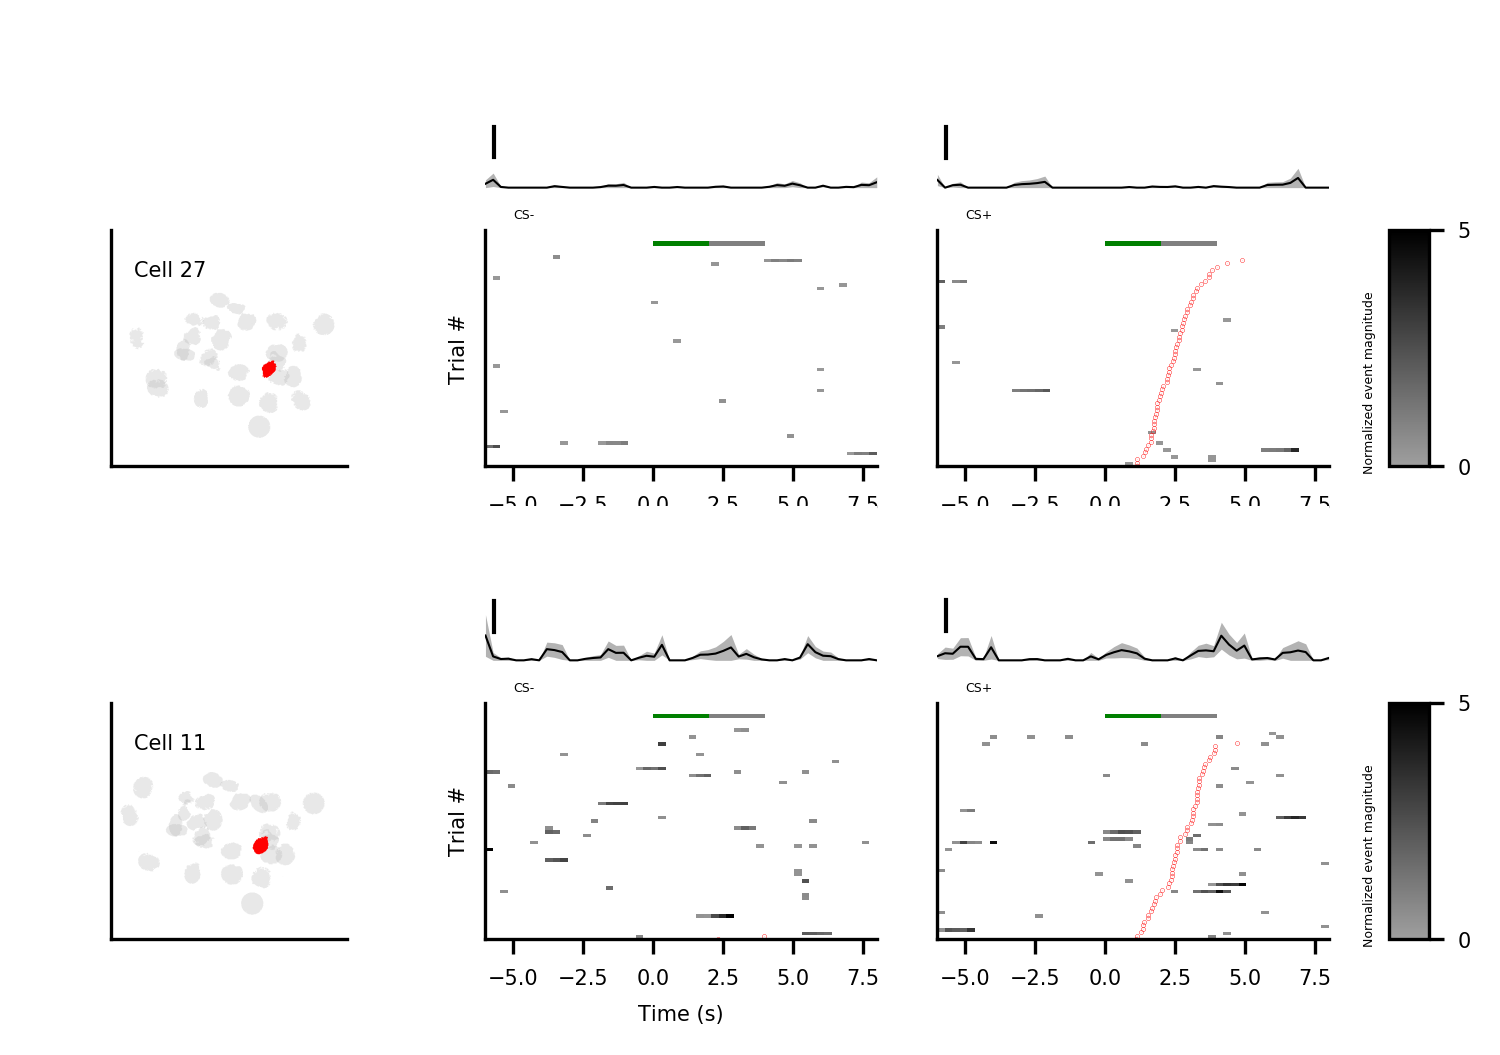

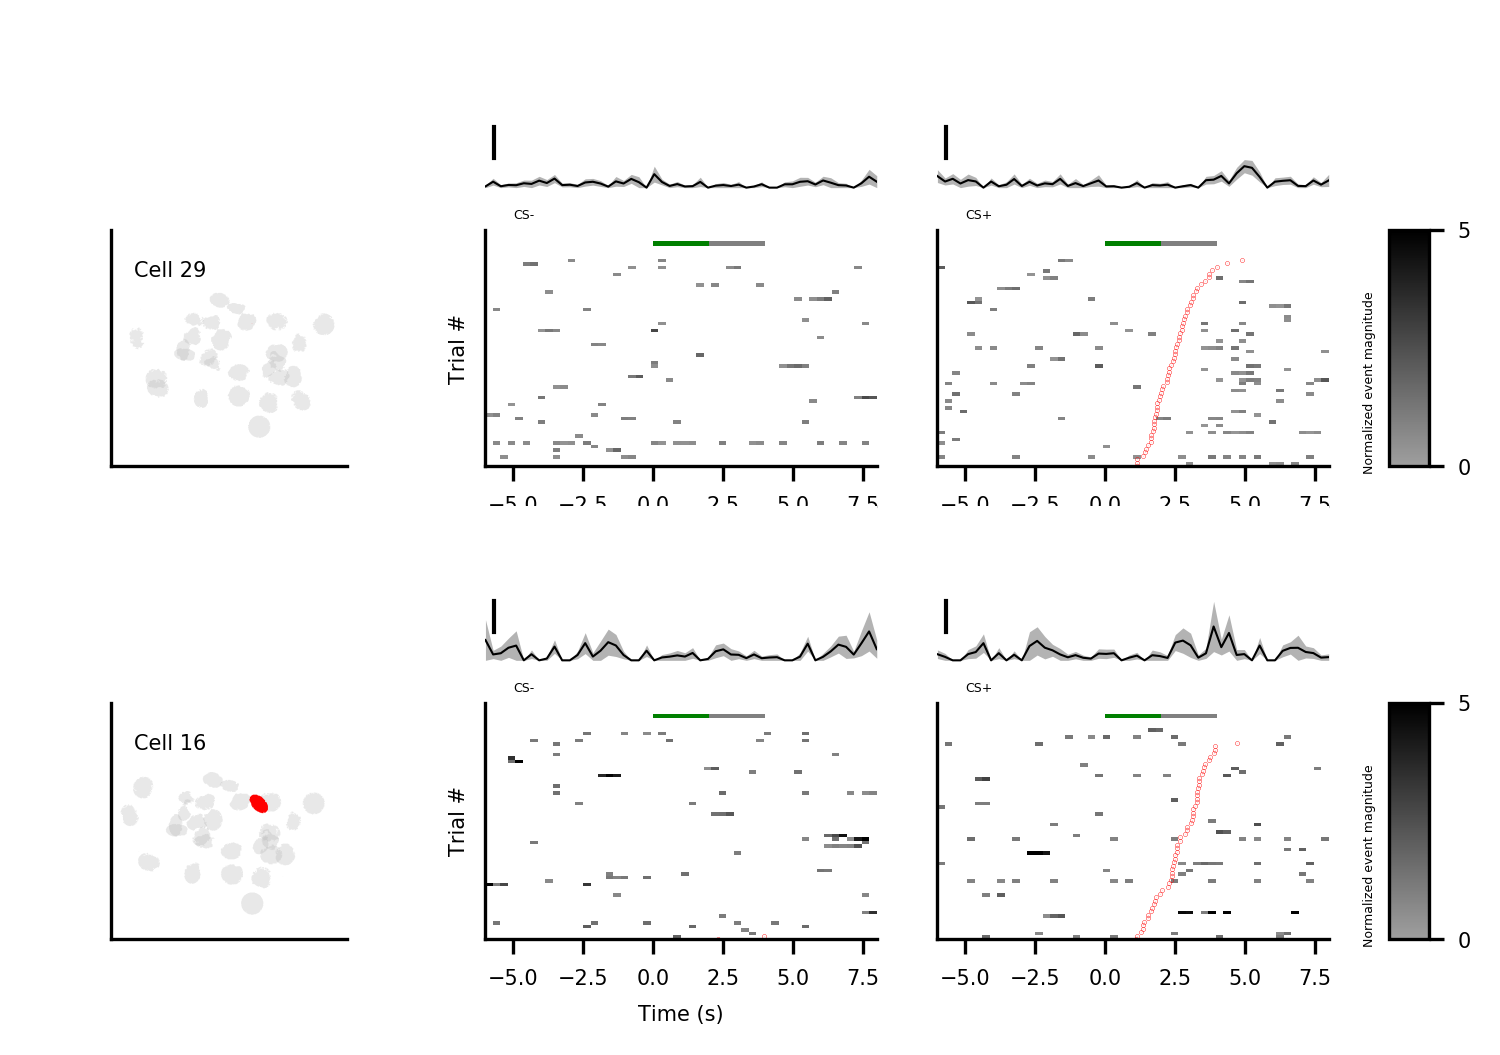

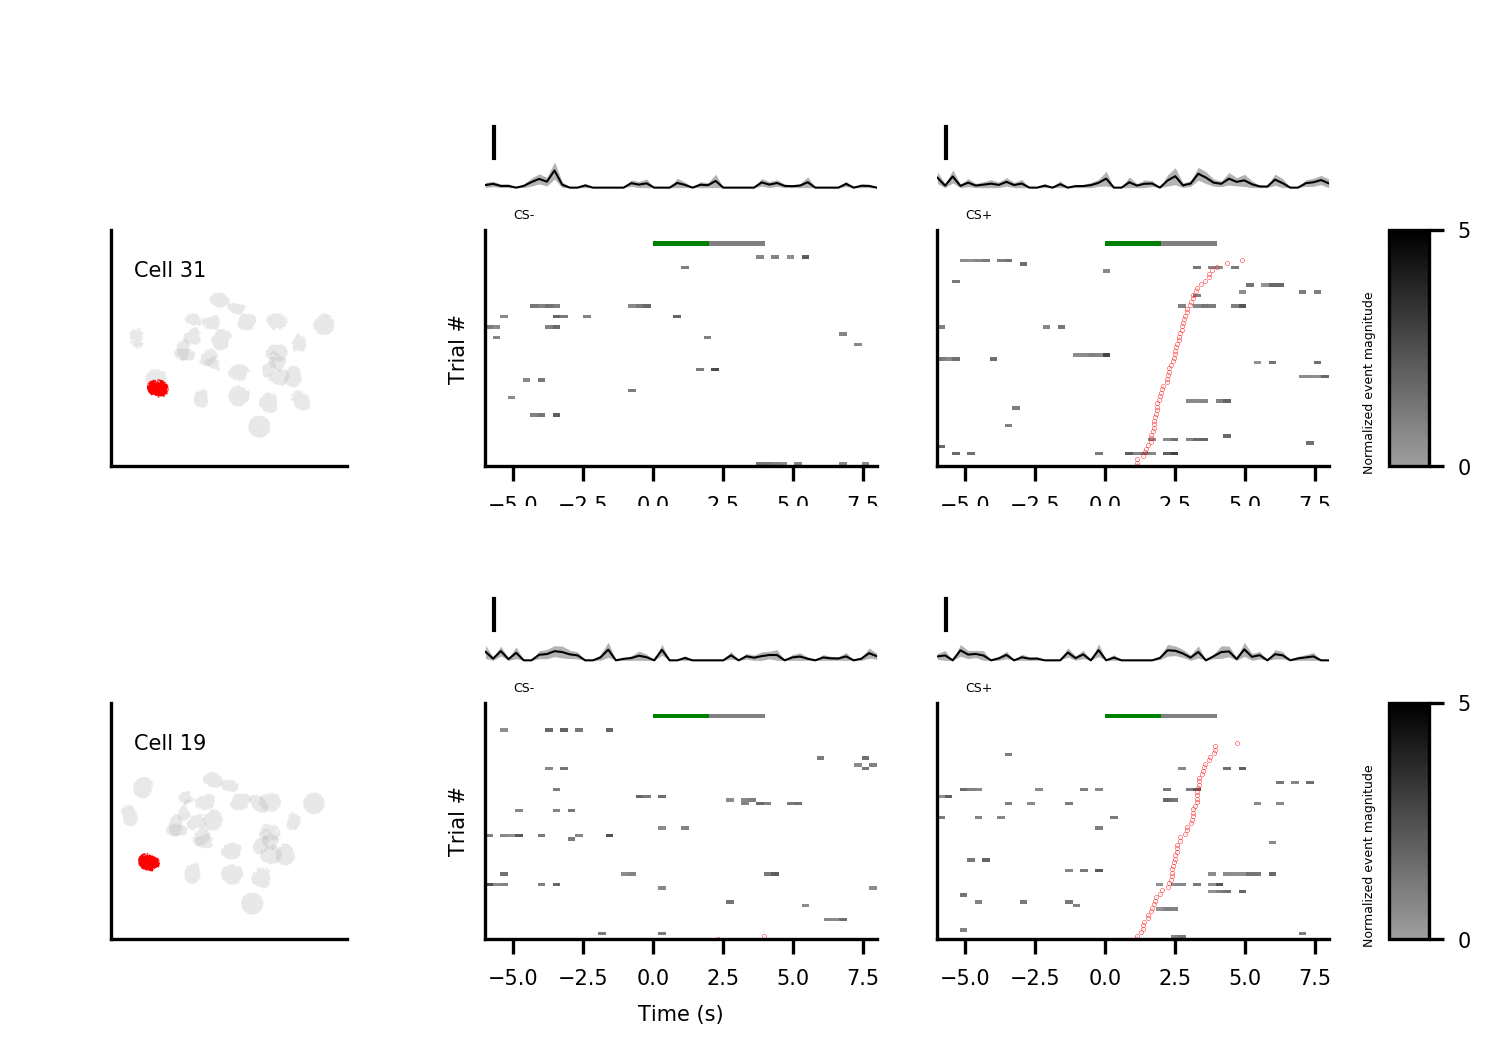

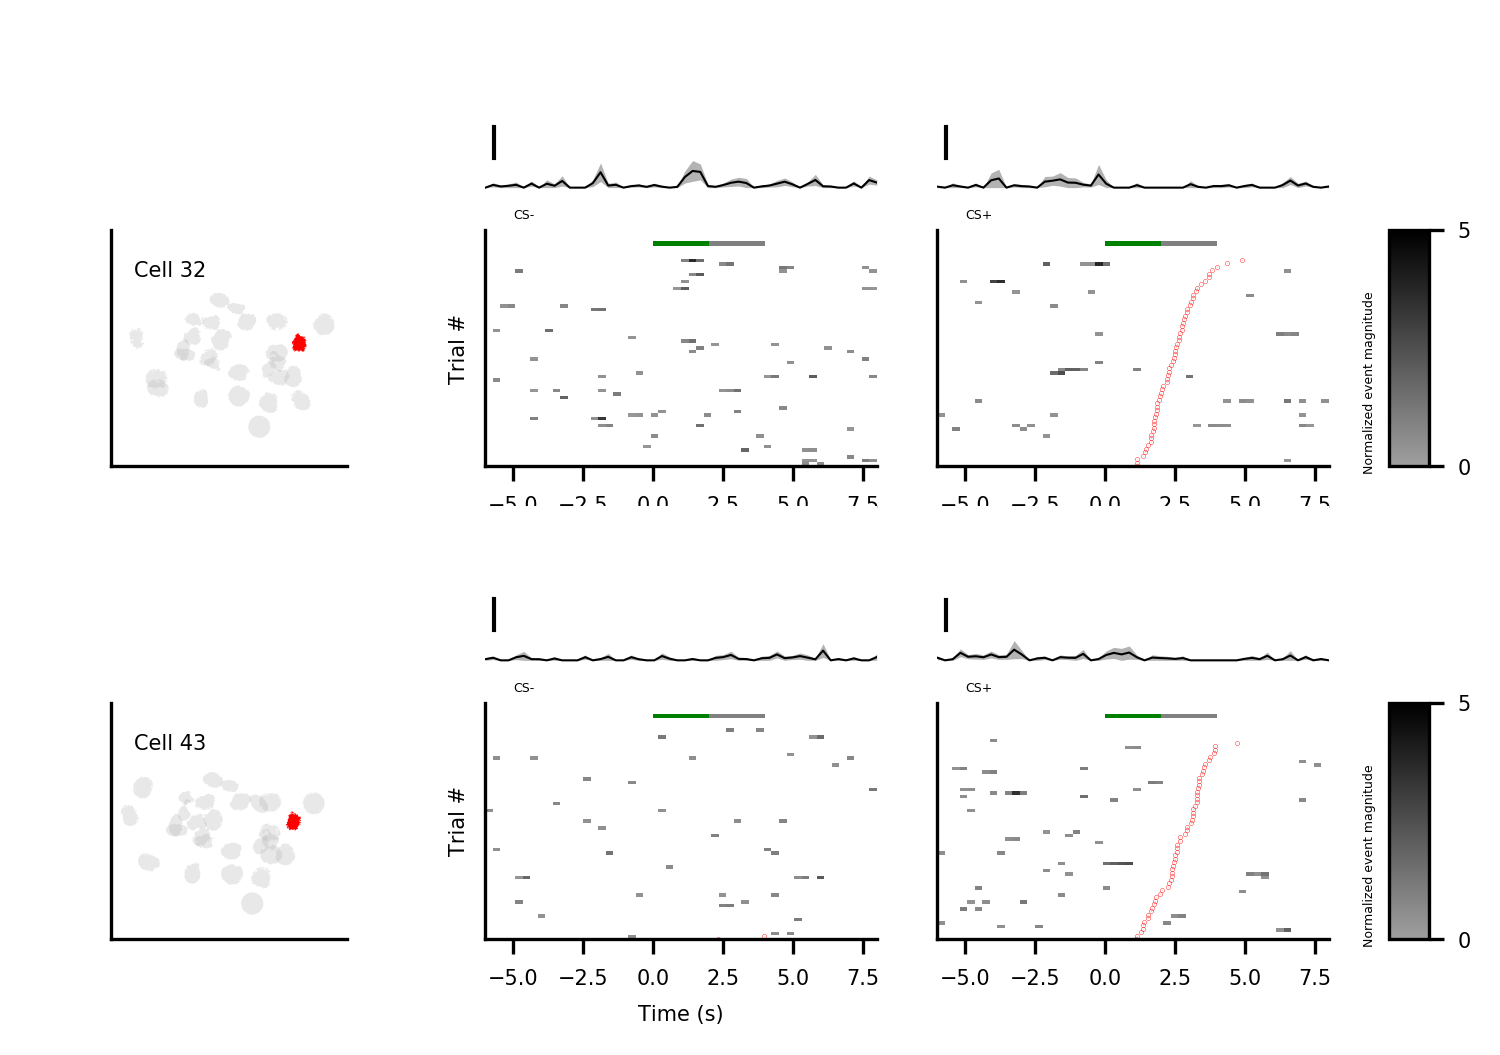

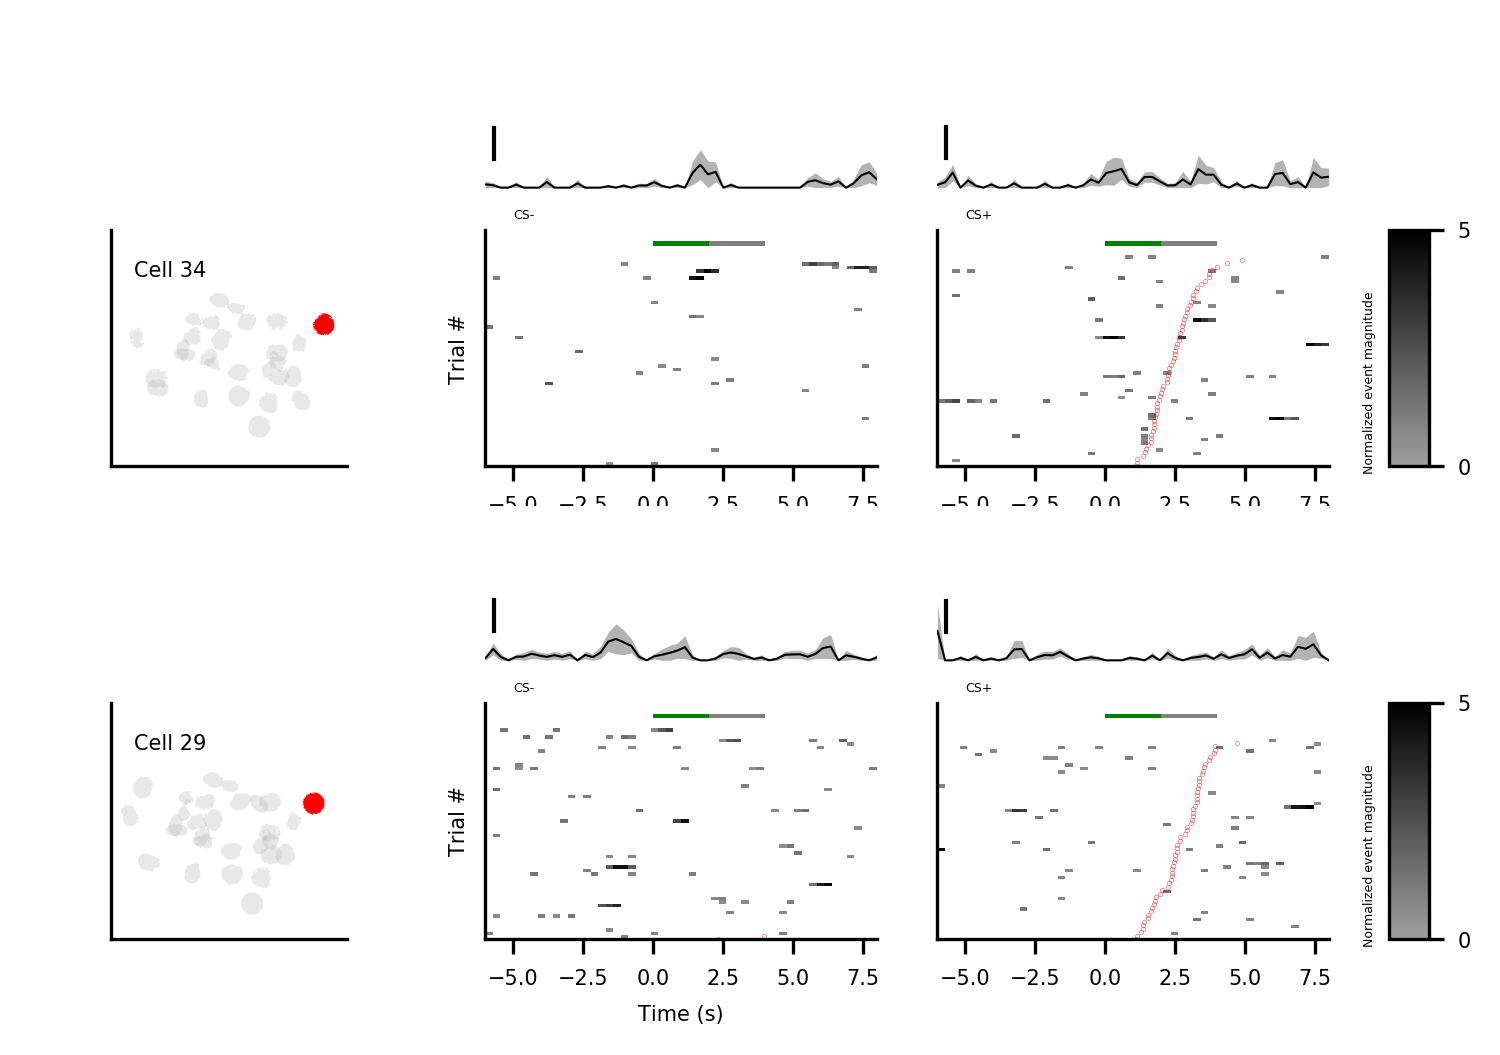

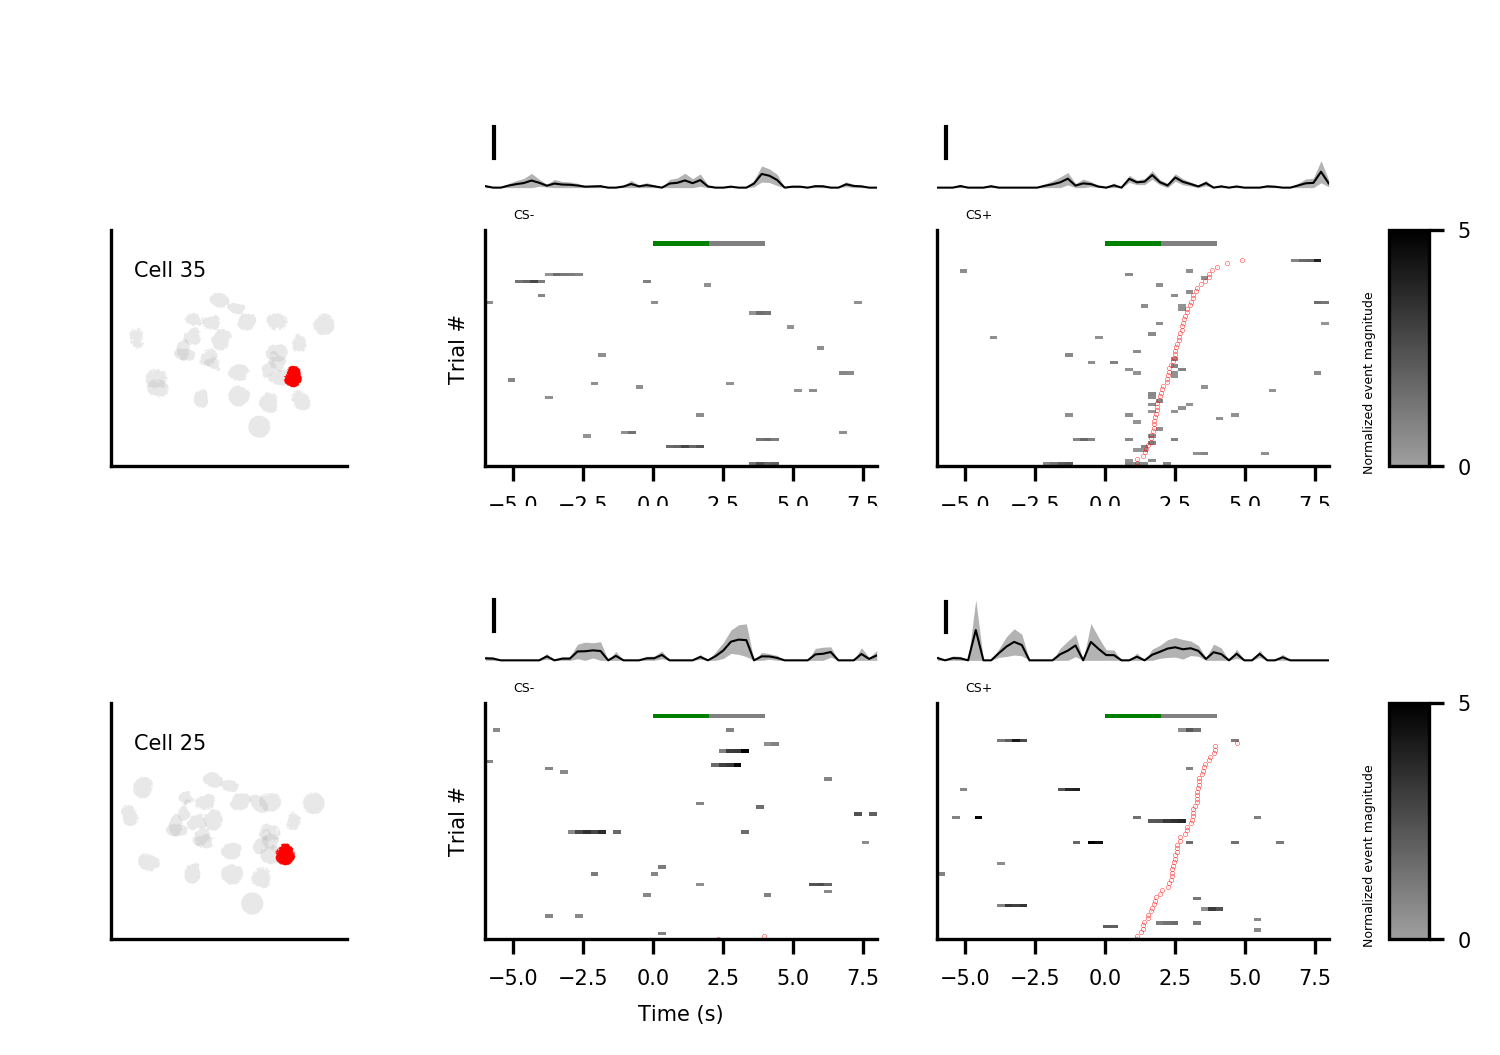

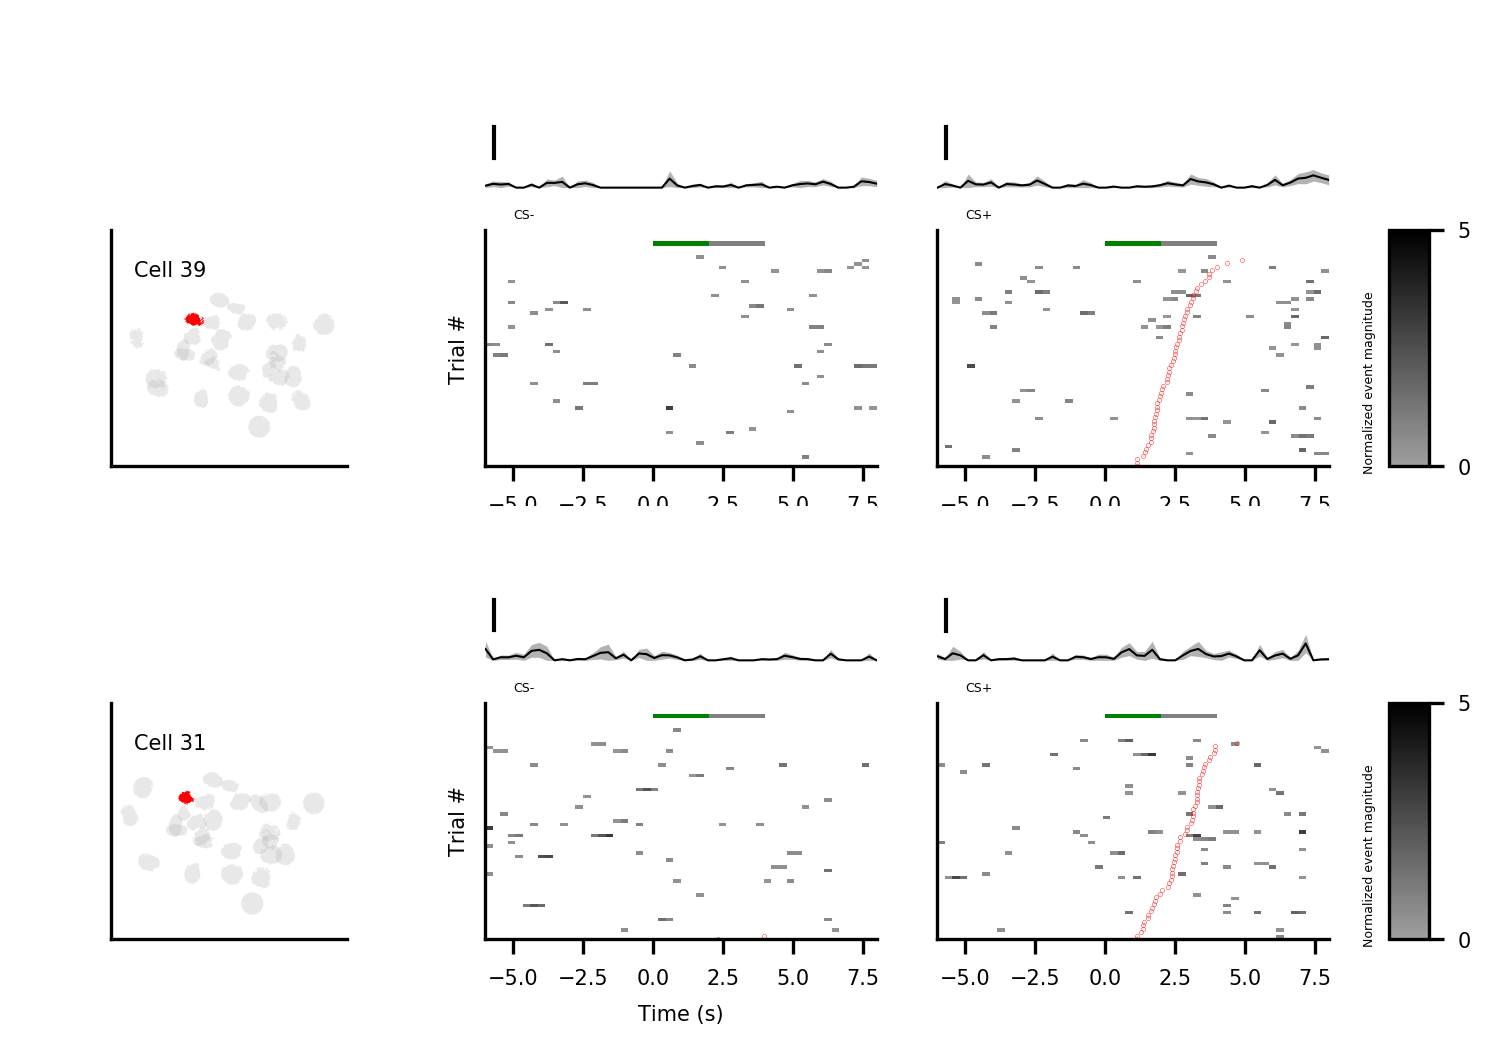

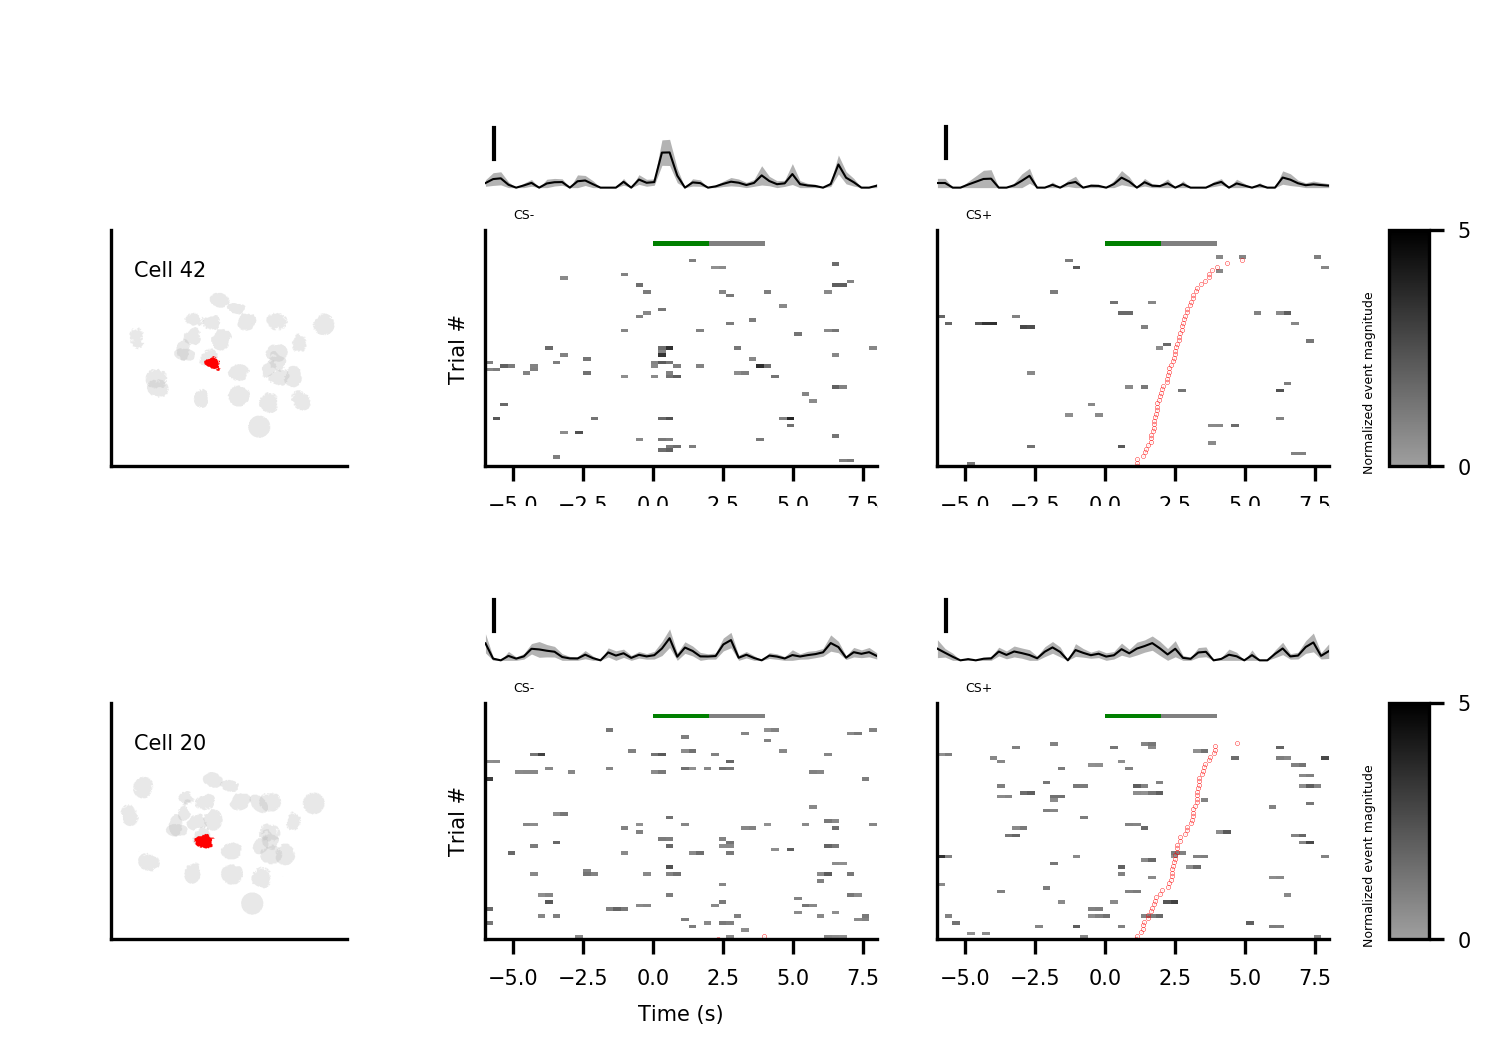

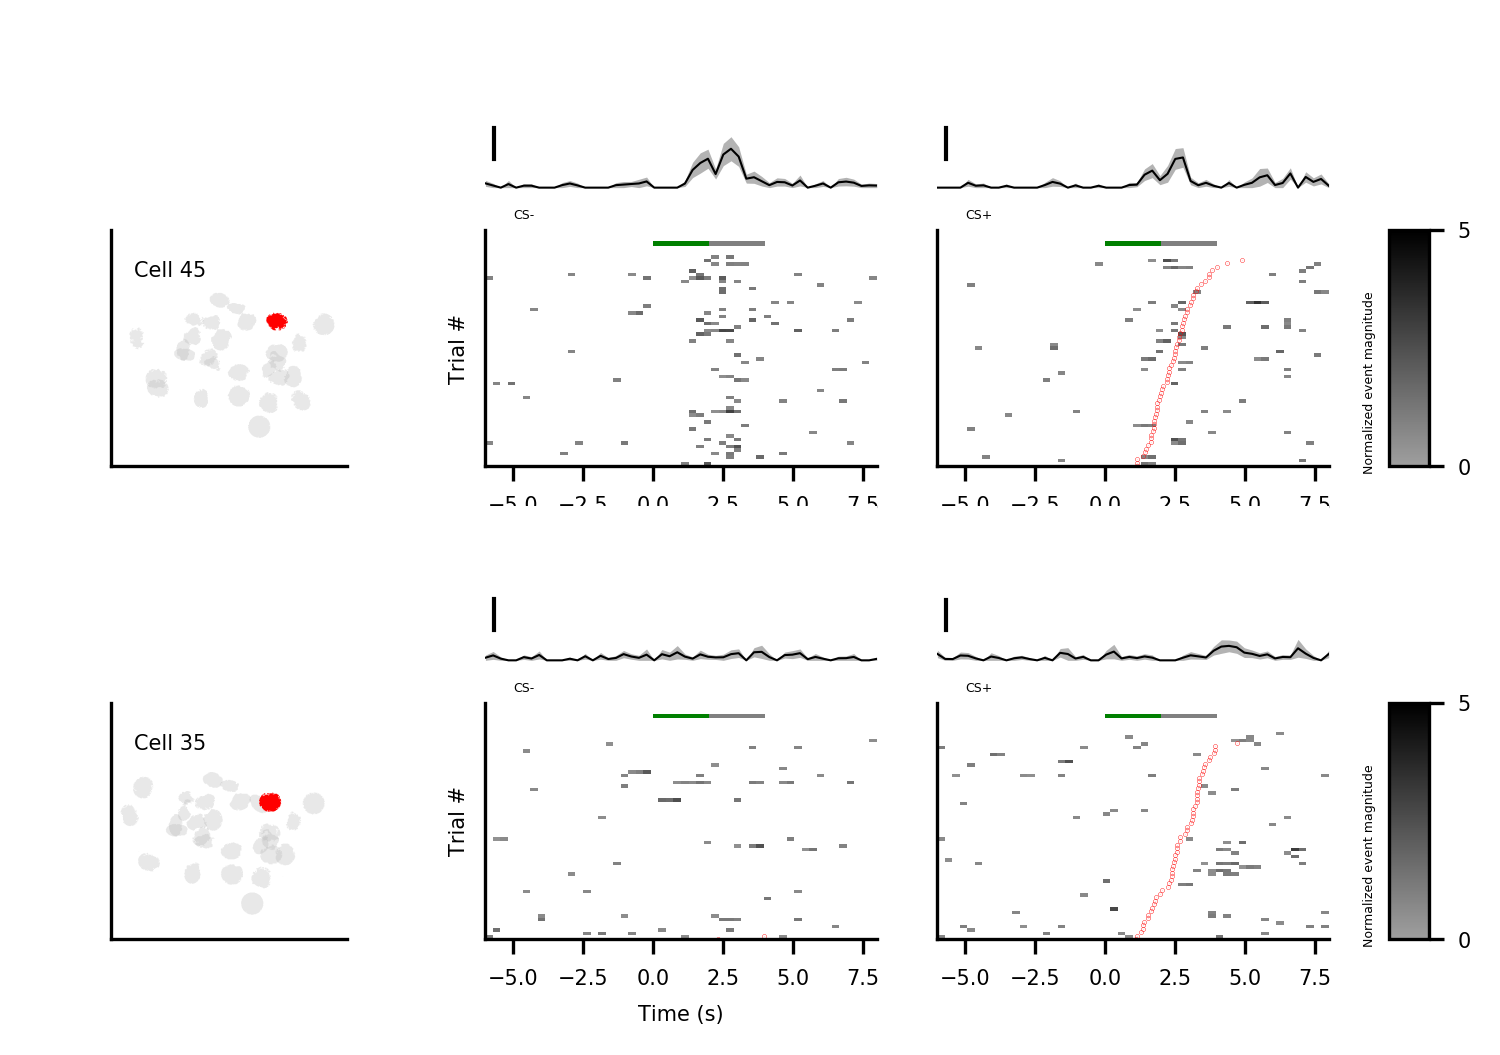

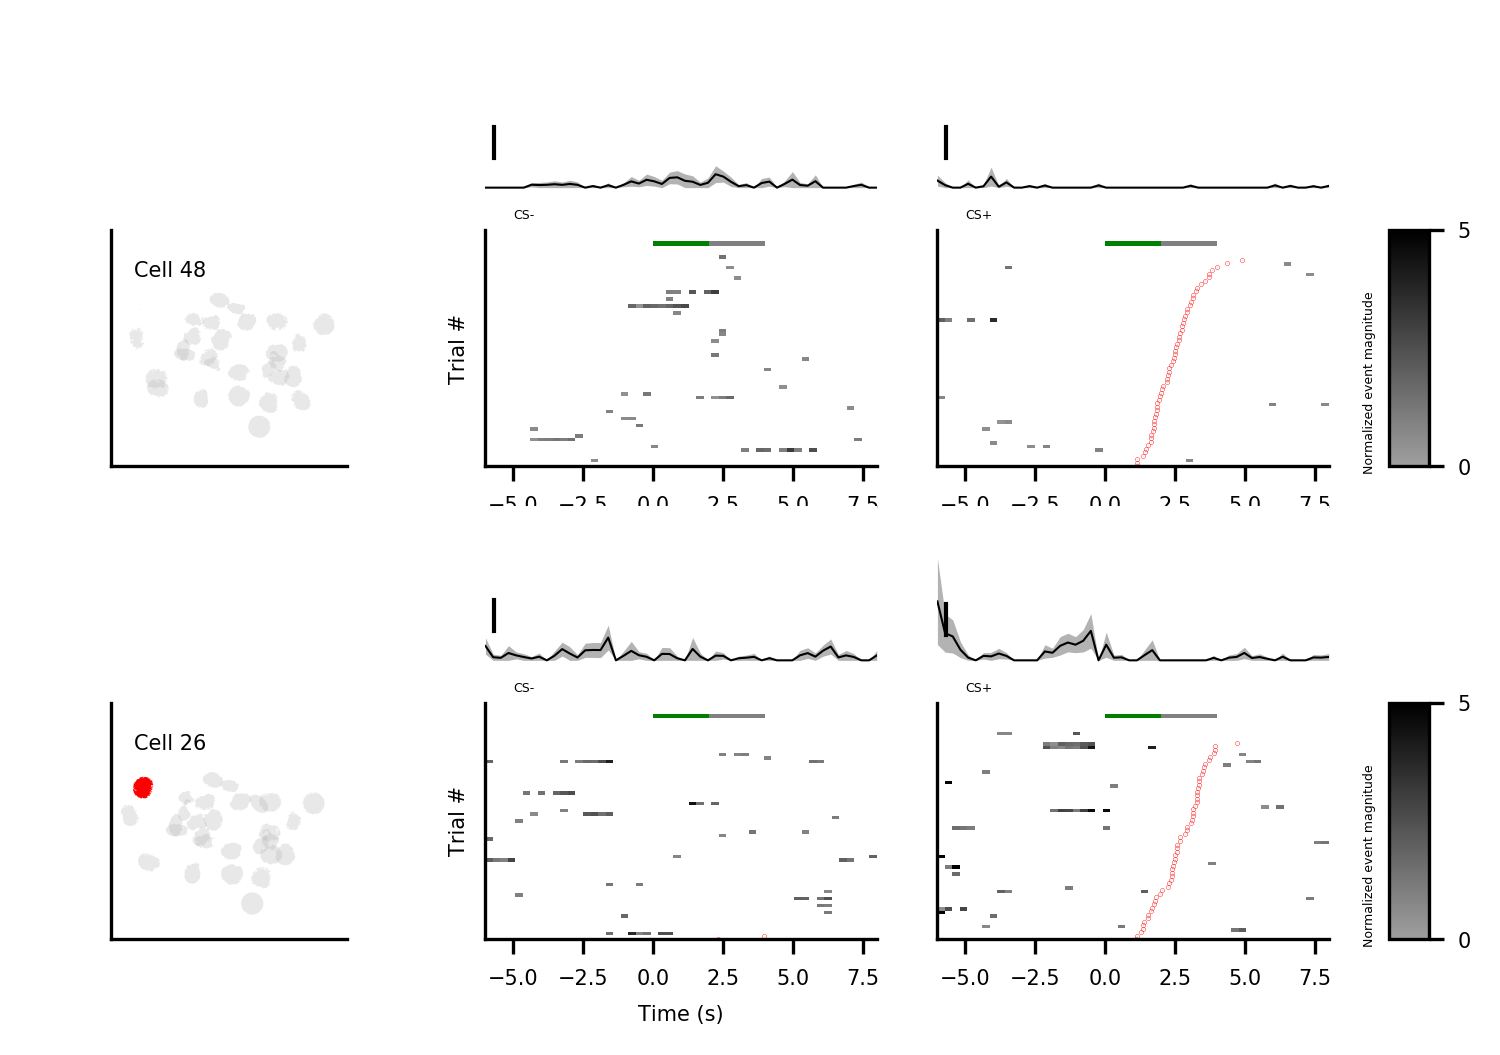

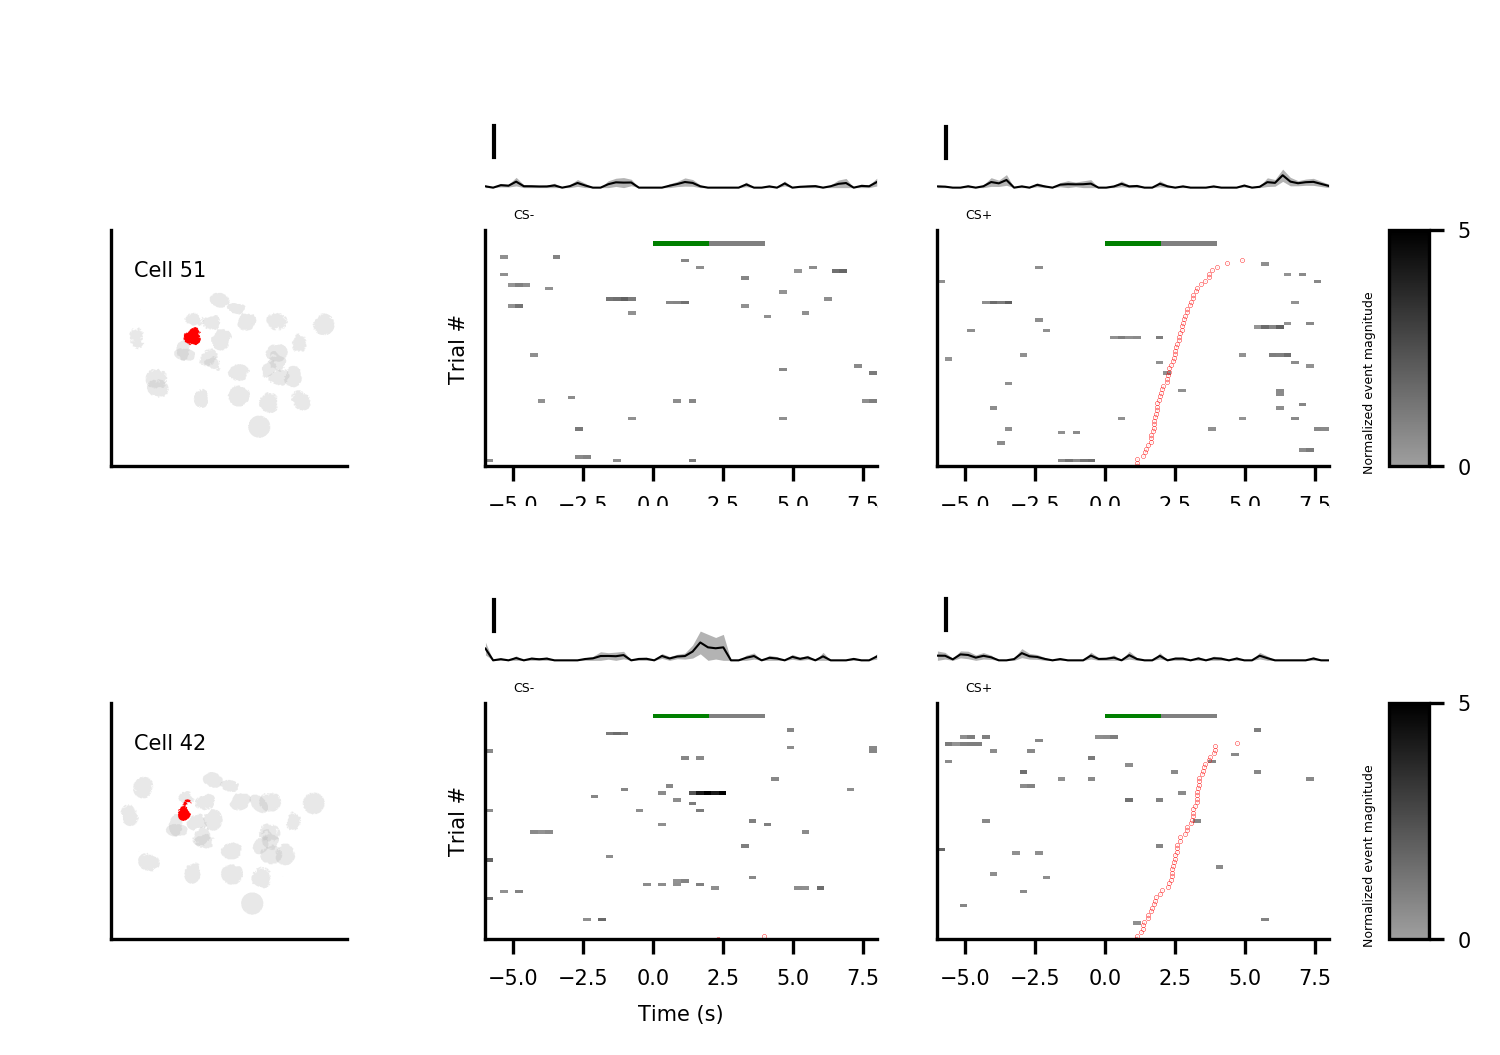

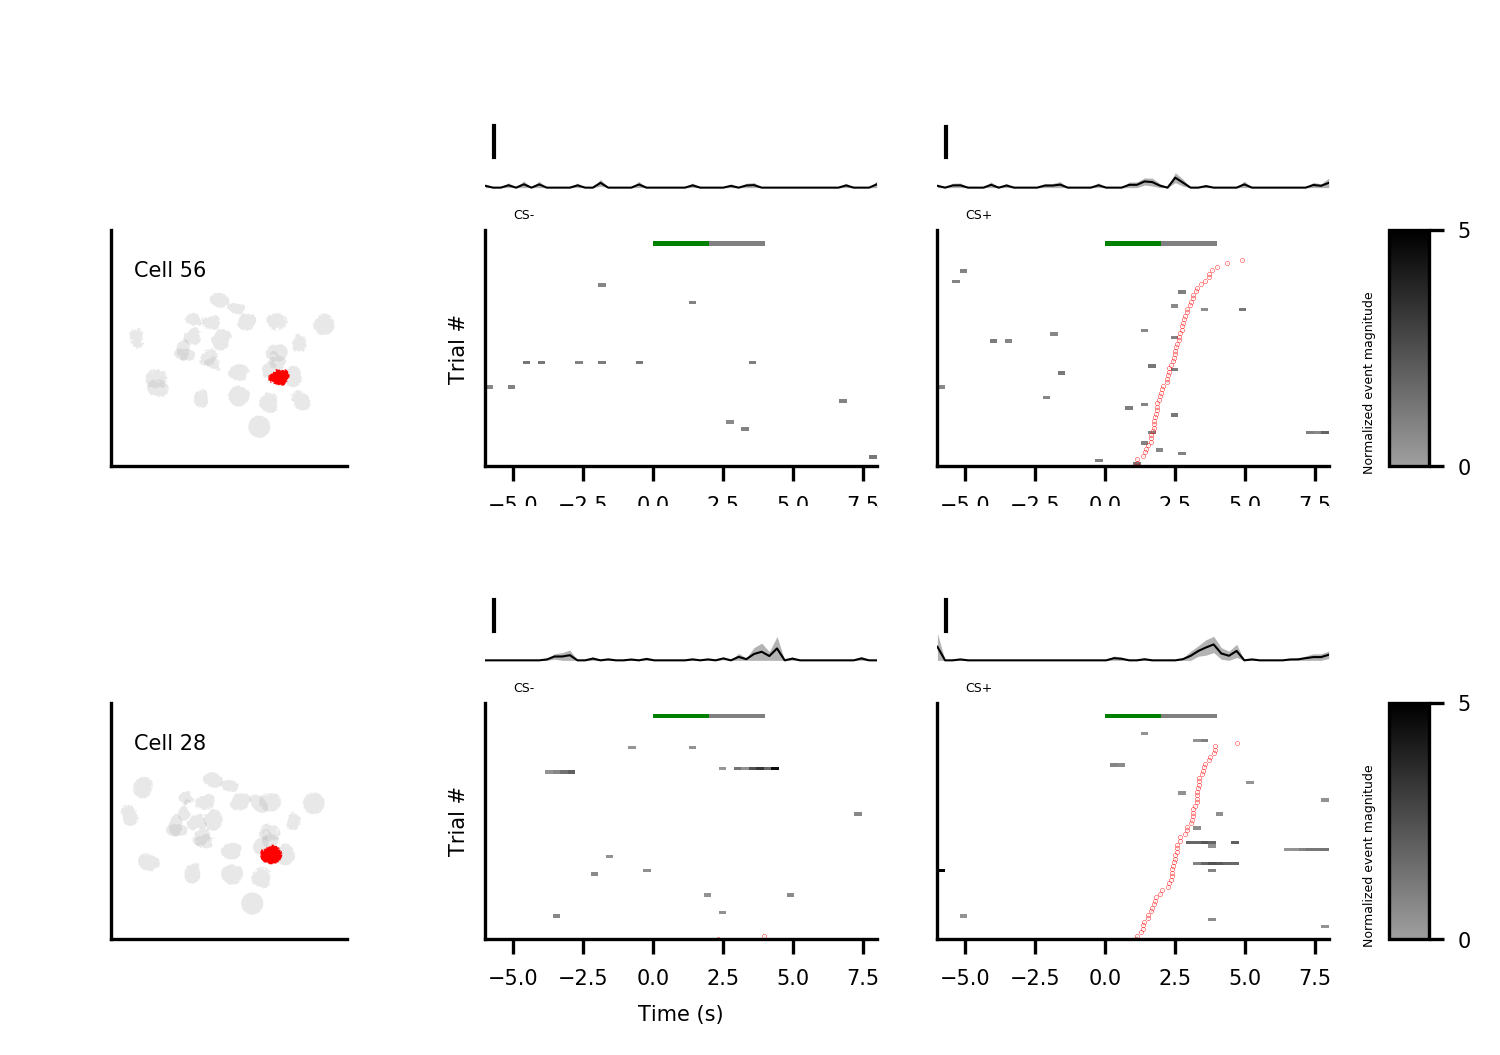

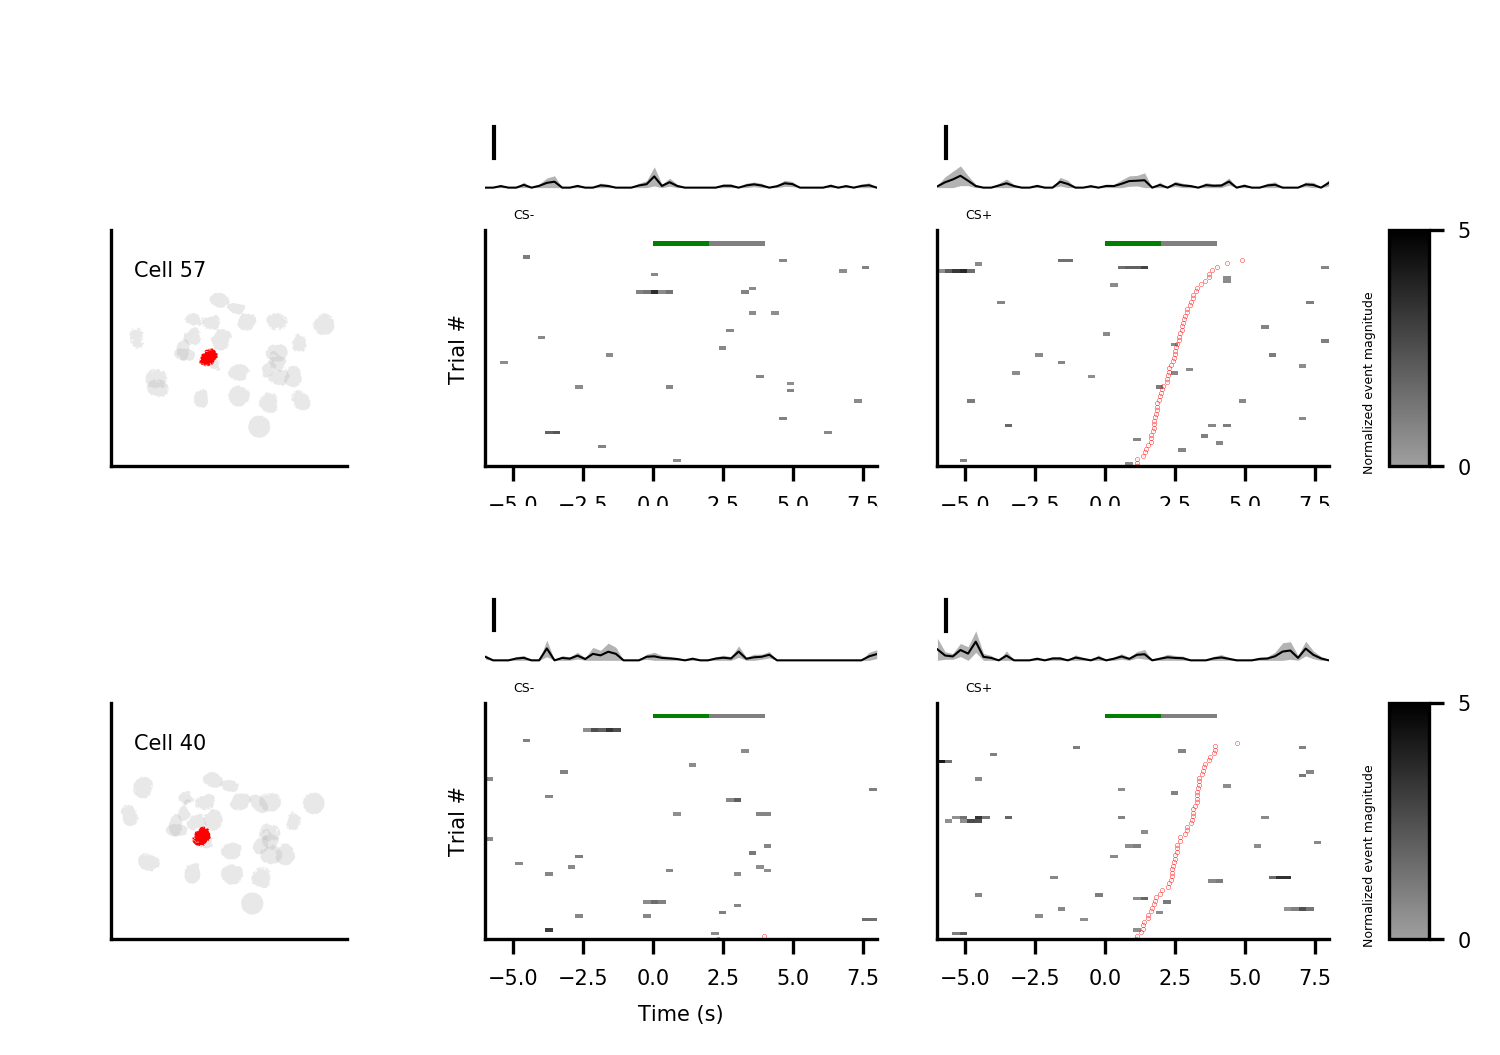

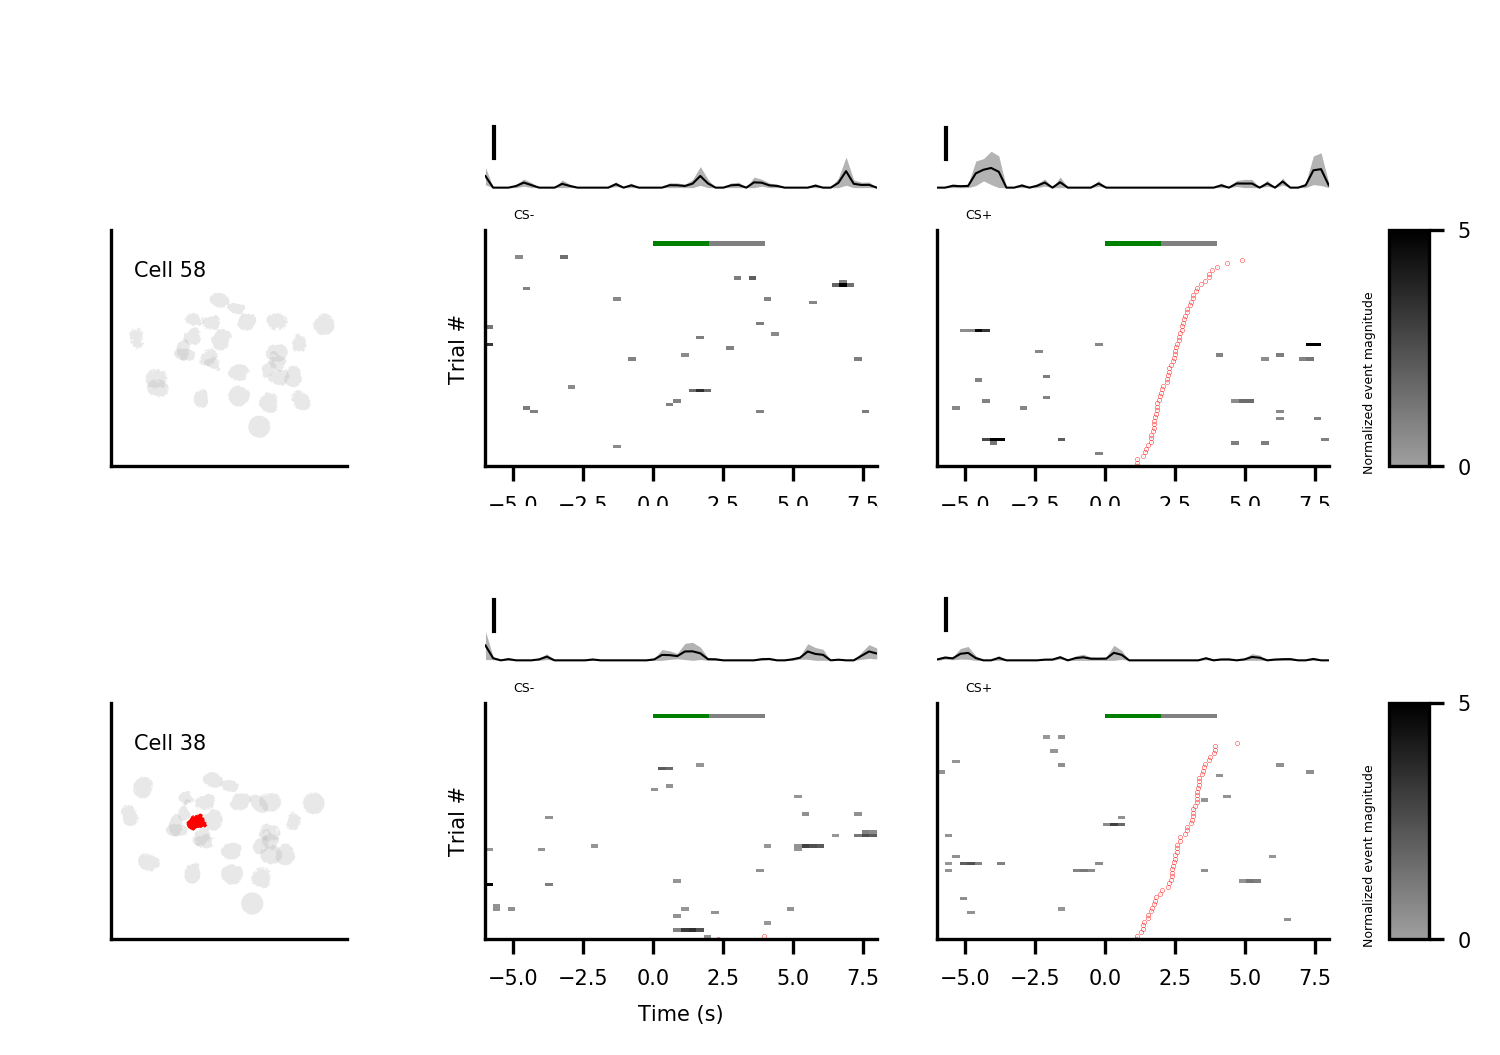

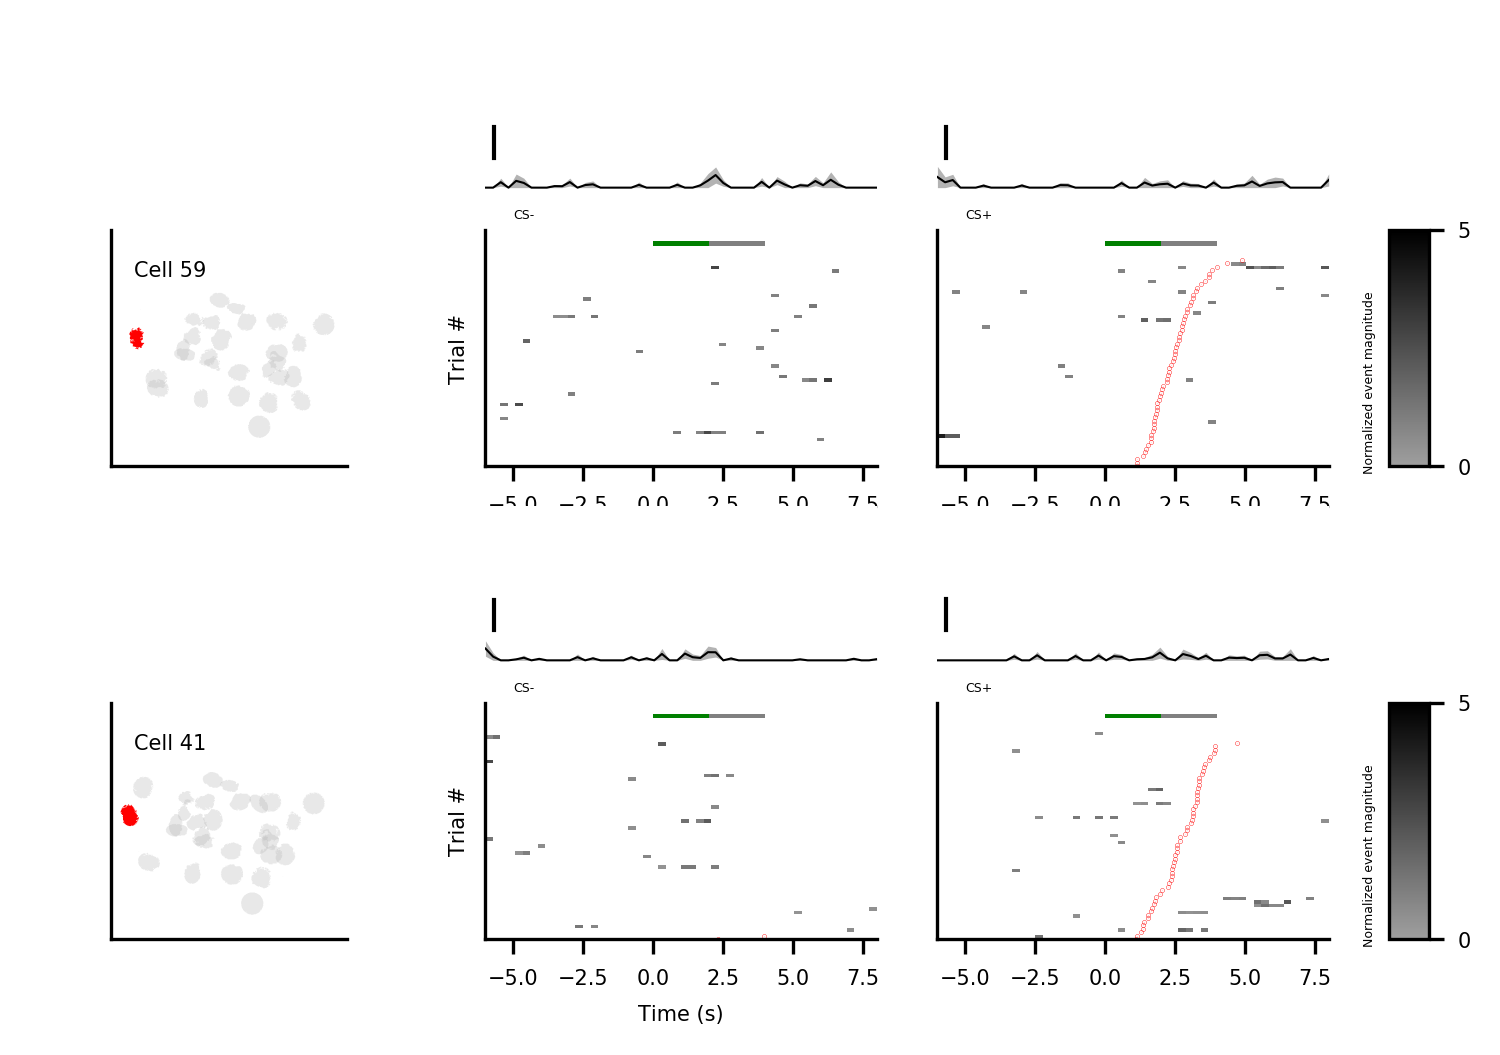

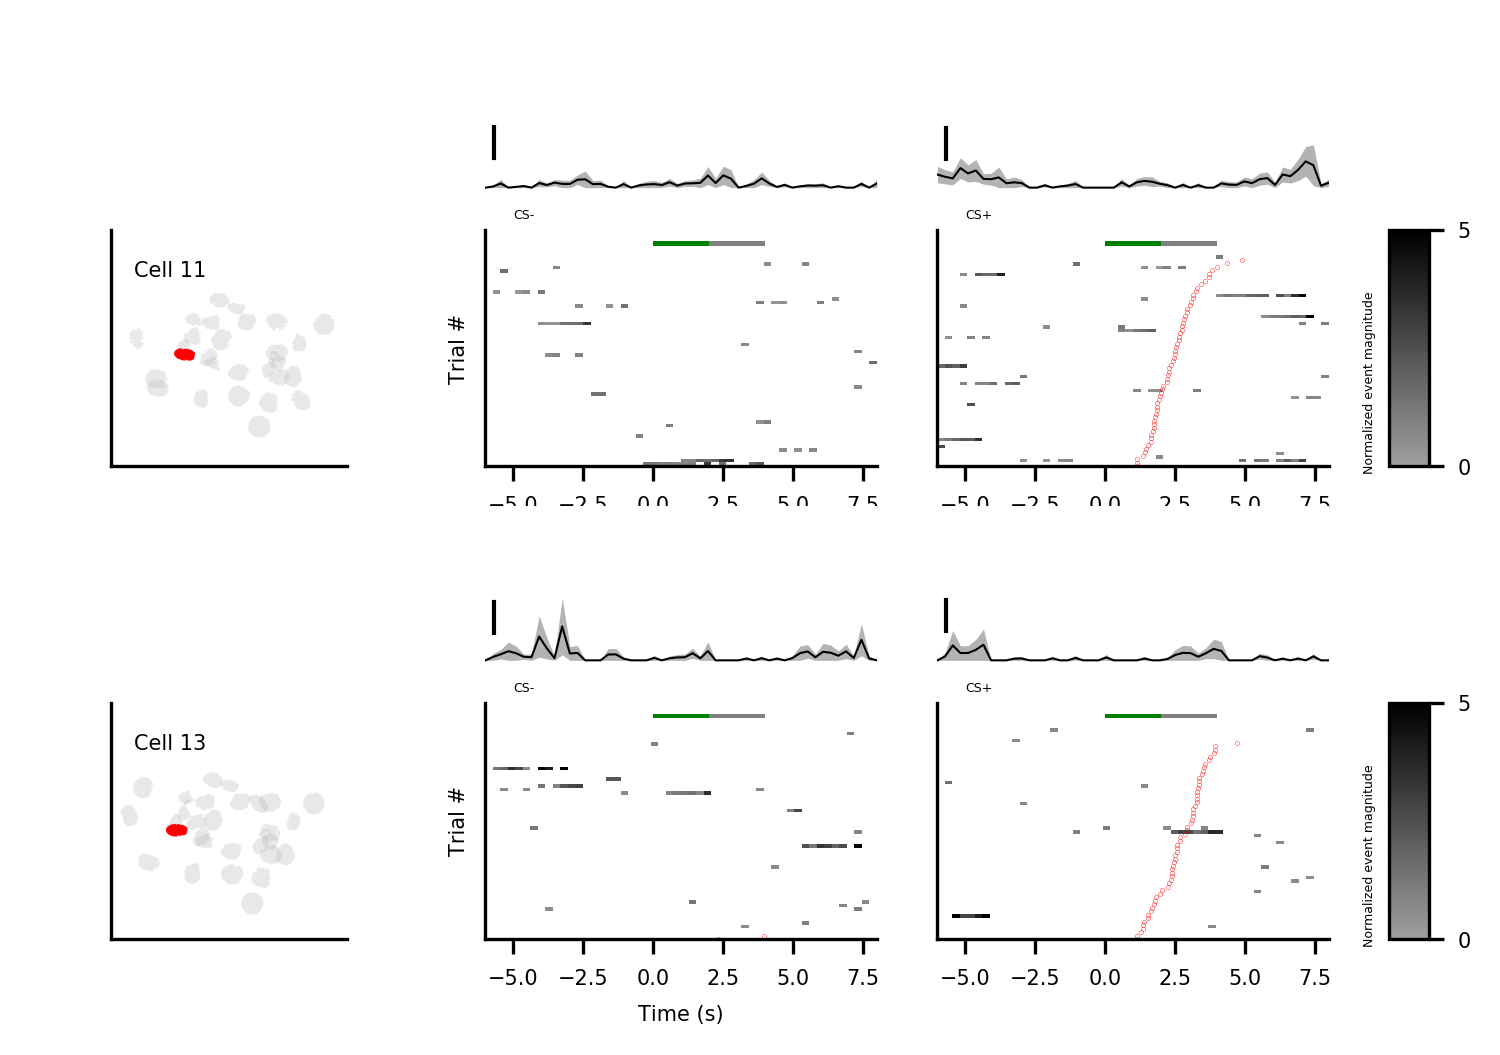

In [17]:
for which in range(len(cellregs['post'])):
#for which in range(1):

    fig, axs = pl.subplots(4, 4, figsize=(6, 4), gridspec_kw={'width_ratios':(1, 1, 1, .1),
                                                                      'height_ratios':(2, 3, 2, 3)},)

    plot_panel(axs[:2], which,
               cmap=pl.cm.gray_r, putnans=True, thr=False, vmin=-3, with_traces=True)
    plot_panel(axs[2:], which,
               cmap=pl.cm.gray_r, putnans=True, thr=False, vmin=-3, with_traces=True, prepost='renew')
    
    fig.savefig('../img/%s__%03d.pdf'%(NOTEBOOK_NAME, cellregs['post'][which]), bbox='tight')

In [18]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
